In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc

#homemade function file
import importlib
import ppe_loading_functions #as functions
importlib.reload(ppe_loading_functions)
import ref_data_functions #as functions
importlib.reload(ref_data_functions)

from pylab import cm
import netCDF4
import numpy as np
from netCDF4 import Dataset

#HM
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import preprocessing
from sklearn.model_selection import KFold, cross_val_score
import random

In [2]:
var1stPPE, results1stPPE,var2ndPPE, results2ndPPE, varMoreCloudParam, resultsMoreCloudParam,\
 varMoreCloudParam2, resultsMoreCloudParam2, varPhyDyn_NewParam_2tun,resultsPhyDyn_NewParam_2tun,\
 varPhyDyn_NewParam_5thPPE_2tun,results_5thPPE_2tun=\
ppe_loading_functions.load_all_ppes()

In [4]:
#Ref tuned ICON-A 2.6.4
pressure_addi,pressure_fact,tauufact,aes_glo_psl,aes_SOO_tauu,aes_NAO_tauu,aes_60N_1000hPa_ua,aes_60S_1000hPa_ua,\
aes_60N_10hPa_ua,aes_60S_10hPa_ua=ref_data_functions.ICON_aes_refdata()

In [5]:
#Physics Ref
ref_mean, ref_std=ref_data_functions.References_outputs()
#Dynamics Ref
refsERA5, refsMERRA2, refsERAInterim=ref_data_functions.References_Dynoutputs()

#all ref values for Physics and Dynamic variables
ref2tun_mean=np.zeros(9)
ref2tun_mean[0:5]=ref_mean #physics variables
ref2tun_mean[5:]=[refsERA5[0],refsERA5[1],refsERA5[2],refsERA5[3]] #dynamics variables
#ref_mean
print(ref2tun_mean)

#all std for Physics and Dynamic variables: not used yet in the HM flow

/home/b/b309216/Bonnet23_GMD_Automatic_Tuning_Atm/jupyter-automatic-tuning-ICON-A/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:26: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  ref_TOASW=file['gsolar_clim'][:]-file['gtoa_sw_all_clim'][:] #m/W^2
/home/b/b309216/Bonnet23_GMD_Automatic_Tuning_Atm/jupyter-automatic-tuning-ICON-A/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:26: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  ref_TOASW=file['gsolar_clim'][:]-file['gtoa_sw_all_clim'][:] #m/W^2
/home/b/b309216/Bonnet23_GMD_Automatic_Tuning_Atm/jupyter-automatic-tuning-ICON-A/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:27: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  ref_TOALW=-file['gtoa_lw_all_clim'][:] #m/W^2
/home/b/b309216/Bonnet23_GMD_Automatic_Tuning_Atm/jupyter-auto

[ 2.40866470e+02 -2.40114889e+02  5.00000000e-01  6.74343643e+01
  2.44086728e+01  1.09413767e+01  3.27732849e+01  2.94719753e-03
  1.36748120e-01]


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/iris/analysis/cartography.py:412: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


In [6]:
ref_Clt_ESACCI, ref_Clt_ESACCI_std, ref_Clt_CLARA_AVHRR, ref_Clt_CLARA_AVHRR_std=ref_data_functions.Ref_clt()
ref_Prw_ESACCI, ref_Prw_ERA5, ref_Prw_ERA5_std=ref_data_functions.Ref_prw()

In [7]:
years_clt_esacci,clt_esacci_per_year=ref_data_functions.clt_esacci_per_years()
years_clt_claraavhrr,clt_claraavhrr_per_year=ref_data_functions.clt_claraavhrr_per_years()
years_prw_era5,prw_era5_per_year=ref_data_functions.prw_era5_per_years()

# Emulator training and performance

In [4]:
#Physics parameters then needs HM
#bounds enlarged for HM
#Emid_bounds = [2e-5, 3e-4] #not in the PhyDyn PPEs
iEpen_bounds = [2e-4, 6e-4] # default value used before is 3.0e-4
iR0top_bounds = [5e-1, 9e-1] # default value used before is 0.8
iCprcon_bounds = [0.00015 , 0.00035] # default value used before is 2.5e-4
iCvtfall_bounds = [0.2 , 4] # default value used before is 2.5
boundsPhy=[iEpen_bounds,iR0top_bounds,iCprcon_bounds,iCvtfall_bounds]
#additional physics parameters
crs_bounds = [0.75*0.968,0.99] #default value used before is 0.968 in src/configure_model/echam_cov_config.f90
csatsc_bounds = [0.7*0.5,0.7*1.5] #default value used before is 0.7 in src/configure_model/echam_cov_config.f90

#Dynamic parameters (same in all notebooks) 
iCd_bounds = [ 0.001, 0.09 ] #default value used in 1st tuning step 0.05 gkwake  = CdCdCd
iG_bounds = [ 0.002, 0.28 ] #default value used in 1st tuning step 0.05 gkdrag  = GGG
isTI_bounds = [ 0.647, 1.079 ] #[ 0.1, 2 ]  # NEW FOR 3rd PhyDyn PPE 0.87/8,0.87*8-> 7 too large, so down to 2 max [ 0.647, 1.079 ] #default value used in 1st tuning step 0.87 rmscon  = sTIsTIsTI
bounds_Dyn2PPE=[iCd_bounds,iG_bounds,isTI_bounds]
#additional dynamic parameters
igpicmea_bounds =[20,60] #[5,320] # NEW FOR 3rd PhyDyn PPE [40/8,40*8] [20,60]#40*0.5,40*1.5 default value used before 40 in src/configure_model/mo_echam_sso_config.f90
igstd_bounds = [5,15] #[1.25,80] # NEW FOR 3rd PhyDyn PPE 10/8,10*8 #[5,15]#10*0.5,10*1.5 default value used before 10 in src/configure_model/mo_echam_sso_config.f90
#iemiss_lev_bounds = [10]#[23:38]#10*0.5,10*1.5 /!\ need to take integers ! default value used before 10 # can use any levels such as 5,6,7,8,9,10,11,12,13,14,15?

boundsPhyDyn=[iEpen_bounds,iR0top_bounds,iCprcon_bounds,iCvtfall_bounds,iCd_bounds,iG_bounds,isTI_bounds]
boundsPhyDyn_newParam=[iEpen_bounds,iR0top_bounds,iCvtfall_bounds,crs_bounds,csatsc_bounds,iCd_bounds,iG_bounds,isTI_bounds,igpicmea_bounds,igstd_bounds]#,iemiss_lev_bounds]


In [16]:
# train the GP on the training sample - only phy parameters
def score_1st_tuning_step(varr,resultss):
            
    randsamples={}

    kernel = 1 * Matern(length_scale=1.0)#, nu=1.5) #RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) #np.array([1.0,1.0,1.0])) #length_scale=10) # ,1.0,1.0,1.0]))#, length_scale_bounds=(1e-2, 1e2))
    gaussian_process_multi = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=100)#,alpha=1e-5, n_restarts_optimizer=20)

    #scale data https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
    scaler_var1_2tun = preprocessing.StandardScaler().fit(varr,)
    scaled_var1_2tun = scaler_var1_2tun.transform(varr)

    Ntot=59 # total size of the sample
    sizeRes_60=np.arange(20,59,4) #[10,15,20,25,30,35,40,45,50,55]
    Nrand=5 # number of times we pick a sample of a given size
    score_isize_60=np.zeros((np.size(sizeRes_60),Nrand))
    score_isize_60_max=np.zeros((np.size(sizeRes_60)))
    score_isize_60_min=np.zeros((np.size(sizeRes_60)))
    score_isize_60_mean=np.zeros((np.size(sizeRes_60)))
    score_isize_60_std=np.zeros((np.size(sizeRes_60)))

    indSi=0
    for Sizz in sizeRes_60:
        indsam={}
        for irand in np.arange(0,Nrand):
            RandSamp=random.sample(range(1,Ntot),Sizz)
            indsam[irand]=RandSamp
            scaled_var1_2tun = scaler_var1_2tun.transform(varr[RandSamp])
            gaussian_process_multi.fit(scaled_var1_2tun, resultss[RandSamp]) #results_dyn_2tun_psltauuNAOSSO #results_all_2tun) #
            gaussian_process_multi.kernel_

            score=cross_val_score(gaussian_process_multi, scaled_var1_2tun, resultss[RandSamp])
            score_isize_60[indSi,irand]=np.mean(score)
            
            randsamples[Sizz]=indsam
            score_isize_60_min[indSi]=np.min(score_isize_60[indSi,:])
            score_isize_60_max[indSi]=np.max(score_isize_60[indSi,:])
            score_isize_60_mean[indSi]=np.mean(score_isize_60[indSi,:])
            score_isize_60_std[indSi]=np.std(score_isize_60[indSi,:])

        indSi+=1
    return sizeRes_60,score_isize_60_mean,score_isize_60_std,Nrand
#duration approx 1min10 (5min33sec)

In [8]:
'''
varr=np.concatenate((var1stPPE,var2ndPPE),axis=0)
resultss=np.concatenate((results1stPPE,results2ndPPE),axis=0) #phy
sizeRes_60_1stt,score_isize_60_mean_1stt,score_isize_60_std_1stt,Nrand_1stt=score_1st_tuning_step(varr,resultss)
'''
#approx 14min30sec

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as 

In [11]:
# save to dictionary the parameter values for the PPEs
namefile = 'Perf_withSize_PPE1_2.pkl'

'''
#to comment once done
perf_PPE1_2 = dict()
perf_PPE1_2['sizeRes_60_1stt']=sizeRes_60_1stt
perf_PPE1_2['score_isize_60_mean_1stt']=score_isize_60_mean_1stt
perf_PPE1_2['score_isize_60_std_1stt']=score_isize_60_std_1stt
perf_PPE1_2['Nrand_1stt']=Nrand_1stt
with open(namefile, 'wb') as f:
    pickle.dump(perf_PPE1_2, f)
'''

"\n### load metrics\nwith open(namefile, 'rb') as f:\n    perf_PPE1_2 = pickle.load(f)\n"

In [5]:
namefile = 'Perf_withSize_PPE1_2.pkl'

with open(namefile, 'rb') as f:
    perf_PPE1_2_loaded = pickle.load(f)


sizeRes_60_1stt=perf_PPE1_2_loaded['sizeRes_60_1stt']
score_isize_60_mean_1stt=perf_PPE1_2_loaded['score_isize_60_mean_1stt']
score_isize_60_std_1stt=perf_PPE1_2_loaded['score_isize_60_std_1stt']
Nrand_1stt=perf_PPE1_2_loaded['Nrand_1stt']

In [17]:
#to comment once done
'''
varr=np.concatenate((varMoreCloudParam,varMoreCloudParam2),axis=0)
resultss=np.concatenate((resultsMoreCloudParam,resultsMoreCloudParam2),axis=0) #phy
sizeRes_60_1stt_More,score_isize_60_mean_1stt_More,score_isize_60_std_1stt_More,Nrand_1stt_More=score_1st_tuning_step(varr,resultss)
'''

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as 

In [18]:
# save to dictionary the parameter values for the PPEs
namefile = 'Perf_withSize_PPE3_4.pkl'

'''
#to comment once done
perf_PPE3_4 = dict()
perf_PPE3_4['sizeRes_60_1stt_More']=sizeRes_60_1stt_More
perf_PPE3_4['score_isize_60_mean_1stt_More']=score_isize_60_mean_1stt_More
perf_PPE3_4['score_isize_60_std_1stt_More']=score_isize_60_std_1stt_More
perf_PPE3_4['Nrand_1stt_More']=Nrand_1stt_More
with open(namefile, 'wb') as f:
    pickle.dump(perf_PPE3_4, f)
'''

In [6]:
namefile = 'Perf_withSize_PPE3_4.pkl'

with open(namefile, 'rb') as f:
    perf_PPE3_4_loaded = pickle.load(f)

sizeRes_60_1stt_More=perf_PPE3_4_loaded['sizeRes_60_1stt_More']
score_isize_60_mean_1stt_More=perf_PPE3_4_loaded['score_isize_60_mean_1stt_More']
score_isize_60_std_1stt_More=perf_PPE3_4_loaded['score_isize_60_std_1stt_More']
Nrand_1stt_More=perf_PPE3_4_loaded['Nrand_1stt_More']

[0 1 2 3 4 5 6 7 8 9]


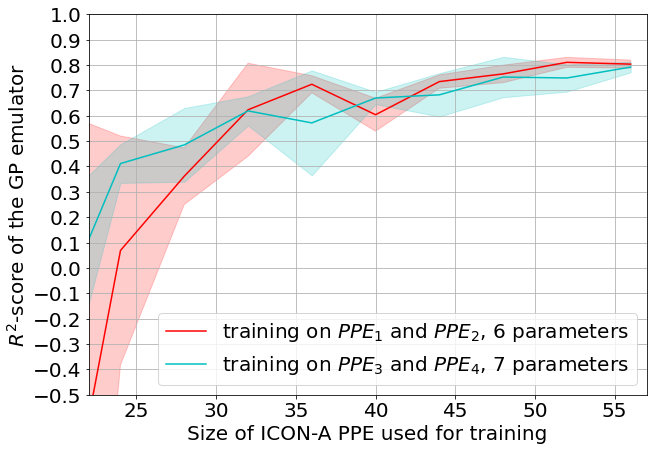

In [9]:
labelPhy=["training on $PPE_1$ and $PPE_2$, 6 parameters","training on $PPE_3$ and $PPE_4$, 7 parameters"]
colors=['r','c']
inddRealistic=np.where(abs(score_isize_60_mean_1stt[:])<1e3)[0] #remove runs that had a bug
inddRealistic_More=np.where(abs(score_isize_60_mean_1stt_More[:])<1e3)[0] #remove runs that had a bug

print(inddRealistic)
plt.subplots()
sizefont=20
plt.rc('font', size=sizefont) 
plt.rcParams['figure.figsize'] = [10, 7]

alp=0.2
iplot=0
plt.plot(sizeRes_60_1stt[inddRealistic],score_isize_60_mean_1stt[inddRealistic],'-',color=colors[iplot],label=labelPhy[iplot])
plt.fill_between(sizeRes_60_1stt[inddRealistic],score_isize_60_mean_1stt[inddRealistic]-score_isize_60_std_1stt[inddRealistic],\
                     score_isize_60_mean_1stt[inddRealistic]+score_isize_60_std_1stt[inddRealistic],\
                        color=colors[iplot],alpha=alp)

iplot=1
plt.plot(sizeRes_60_1stt_More[inddRealistic_More],score_isize_60_mean_1stt_More[inddRealistic_More],'-',color=colors[iplot],label=labelPhy[iplot])
plt.fill_between(sizeRes_60_1stt[inddRealistic_More],score_isize_60_mean_1stt_More[inddRealistic_More]-\
                     score_isize_60_std_1stt_More[inddRealistic_More],score_isize_60_mean_1stt_More[inddRealistic_More]+\
                        score_isize_60_std_1stt_More[inddRealistic_More],color=colors[iplot],alpha=alp)

plt.xlim(22,57)
plt.ylim(-0.5,1)
plt.legend(loc='lower right')
plt.ylabel(r'$R^2$-score of the GP emulator')
plt.xlabel('Size of ICON-A PPE used for training')
plt.yticks(np.arange(-0.5,1.1,0.1))
plt.grid()
#plt.savefig("PaperFig/Performance_Emulator_wrt_size_ICON_PPE_1st_tuning_Step.png")

In [18]:
# train the GP on the training sample - only phy parameters
def score_2nd_tuning_step(varr,resultss):
            
    randsamples={}

    kernel = 1 * Matern(length_scale=1.0)#, nu=1.5) #RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) #np.array([1.0,1.0,1.0])) #length_scale=10) # ,1.0,1.0,1.0]))#, length_scale_bounds=(1e-2, 1e2))
    gaussian_process_multi = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=100)#,alpha=1e-5, n_restarts_optimizer=20)

    #scale data https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
    scaler_var1_2tun = preprocessing.StandardScaler().fit(varr,)
    scaled_var1_2tun = scaler_var1_2tun.transform(varr)

    Ntot=79 # total size of the sample
    sizeRes_80=np.arange(20,78,20) #[10,15,20,25,30,35,40,45,50,55]
    Nrand=5 # number of times we pick a sample of a given size
    score_isize_80=np.zeros((np.size(sizeRes_80),Nrand))
    score_isize_80_max=np.zeros((np.size(sizeRes_80)))
    score_isize_80_min=np.zeros((np.size(sizeRes_80)))
    score_isize_80_mean=np.zeros((np.size(sizeRes_80)))
    score_isize_80_std=np.zeros((np.size(sizeRes_80)))

    indSi=0
    for Sizz in sizeRes_80:
        indsam={}
        for irand in np.arange(0,Nrand):
            RandSamp=random.sample(range(1,Ntot),Sizz)
            indsam[irand]=RandSamp
            scaled_var1_2tun = scaler_var1_2tun.transform(varr[RandSamp])
            gaussian_process_multi.fit(scaled_var1_2tun, resultss[RandSamp]) #results_dyn_2tun_psltauuNAOSSO #results_all_2tun) #
            gaussian_process_multi.kernel_

            score=cross_val_score(gaussian_process_multi, scaled_var1_2tun, resultss[RandSamp])
            score_isize_80[indSi,irand]=np.mean(score)
            
            randsamples[Sizz]=indsam
            score_isize_80_min[indSi]=np.min(score_isize_80[indSi,:])
            score_isize_80_max[indSi]=np.max(score_isize_80[indSi,:])
            score_isize_80_mean[indSi]=np.mean(score_isize_80[indSi,:])
            score_isize_80_std[indSi]=np.std(score_isize_80[indSi,:])

        indSi+=1
    return sizeRes_80,score_isize_80_mean,score_isize_80_std,Nrand
#duration approx 1min10 (5min33sec)

In [20]:
varr=np.concatenate((varPhyDyn_NewParam_2tun,varPhyDyn_NewParam_5thPPE_2tun),axis=0)
resultss=np.concatenate((resultsPhyDyn_NewParam_2tun,results_5thPPE_2tun),axis=0) #phy
sizeRes_80_PhyDyn,score_isize_80_mean_PhyDyn,score_isize_80_std_PhyDyn,Nrand_PhyDyn=score_2nd_tuning_step(varr,resultss)
#approx 2min30sec

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/b/b309216/

In [54]:
#hyperparameter tuning

# 1. effect of the size of the ensemble
## all dynamic outputs
# new hyperparameter tuning steps: take 80% for training, 20% for test
# do first for the size of the ensemble from size 10 to size 48 and sample of size 12 for testing

varr=np.concatenate((var1stPPE,var2ndPPE),axis=0)
ress=np.concatenate((results1stPPE,results2ndPPE),axis=0) #phy

# train the GP on the training sample
'''simu1=[0.5,1e-15,100] #nu, alpha, nrestart
simu2=[0.5,1e-10,100] #nu, alpha, nrestart
simu3=[1.5,1e-10,100] #nu, alpha, nrestart
simu4=[1.5,1e-10,0] #nu, alpha, nrestart
'''
#simu1=[1.5,1e-5,50] #nu, alpha, nrestart
#simu2=[1.5,1e-10,50] #nu, alpha, nrestart
#simu3=[0.5,1e-5,50] #nu, alpha, nrestart
#simu4=[0.5,1e-5,100] #nu, alpha, nrestart
simu0=[1.5,1e-10,0] #nu, alpha, nrestart
simu1=[1.5,1e-10,20] #nu, alpha, nrestart
simu2=[0.5,1e-10,20] #nu, alpha, nrestart
simu3=[0.5,1e-5,20] #nu, alpha, nrestart
simu4=[0.5,1e-12,20] #nu, alpha, nrestart
simu5=[0.5,1e-10,50] #nu, alpha, nrestart
#simu4=[0.5,1e-12,100] #nu, alpha, nrestar

simuhyperparam=[simu0,simu1,simu2,simu3,simu4,simu5]
Nsimu=len(simuhyperparam)


Nrand=20 # number of times we pick a sample of a given size
#for irand in np.arange(0,Nrand): repeat 5 times
totind=range(0,len(varr))
sizetest=8
sizetottrain=len(varr)-sizetest
minsizetrain=62
print(sizetottrain)
sizeRes_2nd_allOut=[20,30,40,50] #np.arange(minsizetrain,sizetottrain,1)

score_isize_2nd_allOut=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu,Nrand))
score_isize_2nd_mean_allOut=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu))
score_isize_2nd_std_allOut=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu))

isimu=0
for simuu in simuhyperparam:
    nuu=simuu[0]
    alphaa=simuu[1]
    n_ress=simuu[2]
    for irand in range(Nrand):
        indtest=random.sample(totind,sizetest) #test set to remove from beginning
        scaler_var = preprocessing.StandardScaler().fit(varr)#[indtest])
        scaled_test = scaler_var.transform(varr[indtest]) 

        notindtest=[x for x in totind if x not in indtest] #all indices except the test indices
        indsam={}
        indSi=0
        for Sizz in sizeRes_2nd_allOut:
            print(Sizz)
            indtrain=random.sample(notindtest,Sizz) #train indices
            indsam[irand]=indtrain
            
            #scaler_var = preprocessing.StandardScaler().fit(varr[indtrain])
            scaled_train= scaler_var.transform(varr[indtrain])
            print('coucou',', irand ',irand,', isimu ', isimu, ', iSizz',Sizz)#,scaled_train) #indSi,indtrain,varr[indtrain],ress[indtrain])
            #scores=gaussian_process_multi.score( scaled_test, ress[indtest]) #scaled_train, ress[indtrain])#
            kernel = 1 * Matern(length_scale=1.0, nu=nuu) 

            gaussian_process_multi = GaussianProcessRegressor(kernel=kernel,alpha=alphaa, n_restarts_optimizer=n_ress)
            resstrain=ress[indtrain]
            resstest=ress[indtest]
            gaussian_process_multi.fit(scaled_train, resstrain) #
            gaussian_process_multi.kernel_

            scores=gaussian_process_multi.score(scaled_test, resstest) #
            print('aft fit', np.mean(scores))
            print(gaussian_process_multi.kernel_)
            
            score_isize_2nd_allOut[indSi,isimu,irand]=np.mean(scores)
            #randsamples_1st[Sizz]=indsam
            indSi+=1
    indSi=0
    for Sizz in sizeRes_2nd_allOut:    
        score_isize_2nd_mean_allOut[indSi,isimu]=np.mean(score_isize_2nd_allOut[indSi,isimu,:])
        score_isize_2nd_std_allOut[indSi,isimu]=np.std(score_isize_2nd_allOut[indSi,isimu,:])
        indSi+=1
    isimu+=1
#duration approx 2min

51
20
coucou , irand  0 , isimu  0 , iSizz 20
aft fit -1.128456520812948
102**2 * Matern(length_scale=53.9, nu=1.5)
30
coucou , irand  0 , isimu  0 , iSizz 30
aft fit -0.43320611720275676
96.3**2 * Matern(length_scale=53.5, nu=1.5)
40
coucou , irand  0 , isimu  0 , iSizz 40
aft fit 0.7634880505551007
97.2**2 * Matern(length_scale=49.2, nu=1.5)
50
coucou , irand  0 , isimu  0 , iSizz 50
aft fit 0.7874520263947309
99**2 * Matern(length_scale=51.1, nu=1.5)
20
coucou , irand  1 , isimu  0 , iSizz 20
aft fit 0.916311603194659
96**2 * Matern(length_scale=55.9, nu=1.5)
30
coucou , irand  1 , isimu  0 , iSizz 30
aft fit 0.8955704505551523
99.4**2 * Matern(length_scale=59.4, nu=1.5)
40
coucou , irand  1 , isimu  0 , iSizz 40
aft fit 0.9207365126889104
98.6**2 * Matern(length_scale=48.9, nu=1.5)
50
coucou , irand  1 , isimu  0 , iSizz 50
aft fit 0.9664916671534476
102**2 * Matern(length_scale=54.1, nu=1.5)
20
coucou , irand  2 , isimu  0 , iSizz 20
aft fit 0.2057378393092657
94.2**2 * Matern(len

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.6282167684719068
98.5**2 * Matern(length_scale=52.1, nu=1.5)
20
coucou , irand  12 , isimu  0 , iSizz 20
aft fit 0.7946952319006237
91.3**2 * Matern(length_scale=52, nu=1.5)
30
coucou , irand  12 , isimu  0 , iSizz 30
aft fit 0.760827460903334
98.2**2 * Matern(length_scale=62.9, nu=1.5)
40
coucou , irand  12 , isimu  0 , iSizz 40
aft fit 0.7812716580181445
99.1**2 * Matern(length_scale=51.6, nu=1.5)
50
coucou , irand  12 , isimu  0 , iSizz 50
aft fit 0.744403014065446
100**2 * Matern(length_scale=53.4, nu=1.5)
20
coucou , irand  13 , isimu  0 , iSizz 20
aft fit 0.037454312889125194
104**2 * Matern(length_scale=65.7, nu=1.5)
30
coucou , irand  13 , isimu  0 , iSizz 30
aft fit 0.5114956051590208
101**2 * Matern(length_scale=54.7, nu=1.5)
40
coucou , irand  13 , isimu  0 , iSizz 40
aft fit 0.4372745765622626
98.3**2 * Matern(length_scale=53.2, nu=1.5)
50
coucou , irand  13 , isimu  0 , iSizz 50
aft fit 0.760264742356985
101**2 * Matern(length_scale=52.4, nu=1.5)
20
coucou , iran

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.6974803670512485
97.3**2 * Matern(length_scale=51.2, nu=1.5)
50
coucou , irand  1 , isimu  1 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.6252792832562719
100**2 * Matern(length_scale=52.8, nu=1.5)
20
coucou , irand  2 , isimu  1 , iSizz 20
aft fit -0.2149644793498319
98.4**2 * Matern(length_scale=64, nu=1.5)
30
coucou , irand  2 , isimu  1 , iSizz 30
aft fit 0.1540362146708064
99.4**2 * Matern(length_scale=59.7, nu=1.5)
40
coucou , irand  2 , isimu  1 , iSizz 40
aft fit 0.28649194517539145
100**2 * Matern(length_scale=60.1, nu=1.5)
50
coucou , irand  2 , isimu  1 , iSizz 50
aft fit 0.5815096951236483
100**2 * Matern(length_scale=56.4, nu=1.5)
20
coucou , irand  3 , isimu  1 , iSizz 20
aft fit 0.7525707396935883
101**2 * Matern(length_scale=69, nu=1.5)
30
coucou , irand  3 , isimu  1 , iSizz 30
aft fit 0.904242379096981
95.1**2 * Matern(length_scale=49.1, nu=1.5)
40
coucou , irand  3 , isimu  1 , iSizz 40
aft fit 0.8703691250009212
102**2 * Matern(length_scale=61.2, nu=1.5)
50
coucou , irand  3 , isimu  1 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.9249512053314435
101**2 * Matern(length_scale=53, nu=1.5)
20
coucou , irand  4 , isimu  1 , iSizz 20
aft fit 0.7728333424498957
96**2 * Matern(length_scale=62.2, nu=1.5)
30
coucou , irand  4 , isimu  1 , iSizz 30
aft fit 0.43491401714383143
95.3**2 * Matern(length_scale=54.8, nu=1.5)
40
coucou , irand  4 , isimu  1 , iSizz 40
aft fit 0.6805251394127625
99.6**2 * Matern(length_scale=57, nu=1.5)
50
coucou , irand  4 , isimu  1 , iSizz 50
aft fit 0.7233779440546378
100**2 * Matern(length_scale=53.4, nu=1.5)
20
coucou , irand  5 , isimu  1 , iSizz 20
aft fit 0.4157758092503743
101**2 * Matern(length_scale=78.5, nu=1.5)
30
coucou , irand  5 , isimu  1 , iSizz 30
aft fit 0.8008704785130083
102**2 * Matern(length_scale=54.1, nu=1.5)
40
coucou , irand  5 , isimu  1 , iSizz 40
aft fit 0.8711402631219227
97.5**2 * Matern(length_scale=52.9, nu=1.5)
50
coucou , irand  5 , isimu  1 , iSizz 50
aft fit 0.8498403236734164
99.3**2 * Matern(length_scale=52.6, nu=1.5)
20
coucou , irand  6 , isi

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.9502192380309445
101**2 * Matern(length_scale=50.4, nu=1.5)
20
coucou , irand  7 , isimu  1 , iSizz 20
aft fit 0.5762217305182743
93.5**2 * Matern(length_scale=50.2, nu=1.5)
30
coucou , irand  7 , isimu  1 , iSizz 30
aft fit 0.7872027272096522
96.3**2 * Matern(length_scale=49.9, nu=1.5)
40
coucou , irand  7 , isimu  1 , iSizz 40
aft fit 0.8485620143592367
99.5**2 * Matern(length_scale=50.2, nu=1.5)
50
coucou , irand  7 , isimu  1 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8311635400814747
102**2 * Matern(length_scale=51.5, nu=1.5)
20
coucou , irand  8 , isimu  1 , iSizz 20
aft fit 0.7817268470883968
99.6**2 * Matern(length_scale=52.9, nu=1.5)
30
coucou , irand  8 , isimu  1 , iSizz 30
aft fit 0.7649358170974125
104**2 * Matern(length_scale=52.1, nu=1.5)
40
coucou , irand  8 , isimu  1 , iSizz 40


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.837182215136987
97.1**2 * Matern(length_scale=54.5, nu=1.5)
50
coucou , irand  8 , isimu  1 , iSizz 50
aft fit 0.8381254429776277
102**2 * Matern(length_scale=53.8, nu=1.5)
20
coucou , irand  9 , isimu  1 , iSizz 20


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.2854408070769767
100**2 * Matern(length_scale=50, nu=1.5)
30
coucou , irand  9 , isimu  1 , iSizz 30
aft fit 0.08136979887767352
102**2 * Matern(length_scale=62.7, nu=1.5)
40
coucou , irand  9 , isimu  1 , iSizz 40
aft fit 0.6394553353684276
102**2 * Matern(length_scale=52.1, nu=1.5)
50
coucou , irand  9 , isimu  1 , iSizz 50
aft fit 0.7037209570380693
101**2 * Matern(length_scale=52, nu=1.5)
20
coucou , irand  10 , isimu  1 , iSizz 20
aft fit 0.7008755717425185
98.3**2 * Matern(length_scale=56.3, nu=1.5)
30
coucou , irand  10 , isimu  1 , iSizz 30
aft fit 0.8164710973383965
103**2 * Matern(length_scale=57.6, nu=1.5)
40
coucou , irand  10 , isimu  1 , iSizz 40
aft fit 0.8287404370349598
100**2 * Matern(length_scale=51.4, nu=1.5)
50
coucou , irand  10 , isimu  1 , iSizz 50
aft fit 0.7918291136537696
102**2 * Matern(length_scale=51.9, nu=1.5)
20
coucou , irand  11 , isimu  1 , iSizz 20
aft fit 0.6406950952771593
95.5**2 * Matern(length_scale=44.4, nu=1.5)
30
coucou , irand  11 

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8951205935296447
99.8**2 * Matern(length_scale=52, nu=1.5)
20
coucou , irand  13 , isimu  1 , iSizz 20
aft fit 0.3650456999376409
102**2 * Matern(length_scale=71.7, nu=1.5)
30
coucou , irand  13 , isimu  1 , iSizz 30
aft fit 0.6778252580741797
101**2 * Matern(length_scale=67, nu=1.5)
40
coucou , irand  13 , isimu  1 , iSizz 40
aft fit 0.48063712999478103
102**2 * Matern(length_scale=55.5, nu=1.5)
50
coucou , irand  13 , isimu  1 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7943576193012658
102**2 * Matern(length_scale=55.6, nu=1.5)
20
coucou , irand  14 , isimu  1 , iSizz 20
aft fit 0.46857674767926155
102**2 * Matern(length_scale=58, nu=1.5)
30
coucou , irand  14 , isimu  1 , iSizz 30
aft fit 0.486095560585592
101**2 * Matern(length_scale=54.5, nu=1.5)
40
coucou , irand  14 , isimu  1 , iSizz 40
aft fit 0.7430496643351814
102**2 * Matern(length_scale=54.9, nu=1.5)
50
coucou , irand  14 , isimu  1 , iSizz 50
aft fit 0.7892544328352367
102**2 * Matern(length_scale=53.5, nu=1.5)
20
coucou , irand  15 , isimu  1 , iSizz 20
aft fit 0.8813671988657965
101**2 * Matern(length_scale=61.7, nu=1.5)
30
coucou , irand  15 , isimu  1 , iSizz 30
aft fit 0.824629386767867
106**2 * Matern(length_scale=62.1, nu=1.5)
40
coucou , irand  15 , isimu  1 , iSizz 40
aft fit 0.9165477988281536
101**2 * Matern(length_scale=58.4, nu=1.5)
50
coucou , irand  15 , isimu  1 , iSizz 50
aft fit 0.8753299502225442
102**2 * Matern(length_scale=52, nu=1.5)
20
coucou , irand  16 ,

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7306547741807382
99.8**2 * Matern(length_scale=50.7, nu=1.5)
50
coucou , irand  17 , isimu  1 , iSizz 50
aft fit 0.813715217260248
101**2 * Matern(length_scale=51.1, nu=1.5)
20
coucou , irand  18 , isimu  1 , iSizz 20
aft fit 0.7632423044929342
98.1**2 * Matern(length_scale=60.2, nu=1.5)
30
coucou , irand  18 , isimu  1 , iSizz 30


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.6917833821665278
96**2 * Matern(length_scale=48.7, nu=1.5)
40
coucou , irand  18 , isimu  1 , iSizz 40
aft fit 0.6550508224081575
97.8**2 * Matern(length_scale=51.7, nu=1.5)
50
coucou , irand  18 , isimu  1 , iSizz 50
aft fit 0.8285679734428472
101**2 * Matern(length_scale=51.5, nu=1.5)
20
coucou , irand  19 , isimu  1 , iSizz 20
aft fit -0.0013982555829568089
95.1**2 * Matern(length_scale=56.8, nu=1.5)
30
coucou , irand  19 , isimu  1 , iSizz 30
aft fit 0.706756108925813
98.7**2 * Matern(length_scale=53.1, nu=1.5)
40
coucou , irand  19 , isimu  1 , iSizz 40
aft fit 0.7303885790480438
101**2 * Matern(length_scale=53.3, nu=1.5)
50
coucou , irand  19 , isimu  1 , iSizz 50
aft fit 0.8239388527043368
99.5**2 * Matern(length_scale=51.6, nu=1.5)
20
coucou , irand  0 , isimu  2 , iSizz 20
aft fit 0.819714193963582
155**2 * Matern(length_scale=2.57e+04, nu=0.5)
30
coucou , irand  0 , isimu  2 , iSizz 30
aft fit 0.8751253678971741
156**2 * Matern(length_scale=2.48e+04, nu=0.5)
40
couc

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.6465816105952789
156**2 * Matern(length_scale=3.12e+04, nu=0.5)
50
coucou , irand  6 , isimu  2 , iSizz 50
aft fit 0.8000441982583532
156**2 * Matern(length_scale=3.3e+04, nu=0.5)
20
coucou , irand  7 , isimu  2 , iSizz 20
aft fit 0.7621384734947424
156**2 * Matern(length_scale=2.05e+04, nu=0.5)
30
coucou , irand  7 , isimu  2 , iSizz 30
aft fit 0.5717157279532238
156**2 * Matern(length_scale=2.7e+04, nu=0.5)
40
coucou , irand  7 , isimu  2 , iSizz 40
aft fit 0.7354283176087442
156**2 * Matern(length_scale=3.12e+04, nu=0.5)
50
coucou , irand  7 , isimu  2 , iSizz 50
aft fit 0.7543716694461848
156**2 * Matern(length_scale=3.43e+04, nu=0.5)
20
coucou , irand  8 , isimu  2 , iSizz 20
aft fit 0.6855787852790469
155**2 * Matern(length_scale=2.65e+04, nu=0.5)
30
coucou , irand  8 , isimu  2 , iSizz 30
aft fit 0.7502142730460895
156**2 * Matern(length_scale=3.83e+04, nu=0.5)
40
coucou , irand  8 , isimu  2 , iSizz 40


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7895210762929514
156**2 * Matern(length_scale=3.33e+04, nu=0.5)
50
coucou , irand  8 , isimu  2 , iSizz 50
aft fit 0.8150042505959811
156**2 * Matern(length_scale=3.79e+04, nu=0.5)
20
coucou , irand  9 , isimu  2 , iSizz 20
aft fit 0.5233911453691068
155**2 * Matern(length_scale=2.87e+04, nu=0.5)
30
coucou , irand  9 , isimu  2 , iSizz 30
aft fit 0.5720069019474245
156**2 * Matern(length_scale=2.59e+04, nu=0.5)
40
coucou , irand  9 , isimu  2 , iSizz 40
aft fit 0.7194588912048306
156**2 * Matern(length_scale=3.42e+04, nu=0.5)
50
coucou , irand  9 , isimu  2 , iSizz 50
aft fit 0.6372560459918475
156**2 * Matern(length_scale=3.6e+04, nu=0.5)
20
coucou , irand  10 , isimu  2 , iSizz 20
aft fit 0.7475392021870794
155**2 * Matern(length_scale=2.47e+04, nu=0.5)
30
coucou , irand  10 , isimu  2 , iSizz 30
aft fit 0.8503612850262213
156**2 * Matern(length_scale=2.76e+04, nu=0.5)
40
coucou , irand  10 , isimu  2 , iSizz 40
aft fit 0.8461042307085271
156**2 * Matern(length_scale=3.15e+

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8934457176082187
156**2 * Matern(length_scale=3.22e+04, nu=0.5)
20
coucou , irand  15 , isimu  2 , iSizz 20
aft fit 0.7455139267328782
156**2 * Matern(length_scale=3.33e+04, nu=0.5)
30
coucou , irand  15 , isimu  2 , iSizz 30
aft fit 0.7921223683244598
155**2 * Matern(length_scale=3.18e+04, nu=0.5)
40
coucou , irand  15 , isimu  2 , iSizz 40
aft fit 0.8196096313797103
156**2 * Matern(length_scale=2.98e+04, nu=0.5)
50
coucou , irand  15 , isimu  2 , iSizz 50
aft fit 0.8371096247593972
156**2 * Matern(length_scale=3.24e+04, nu=0.5)
20
coucou , irand  16 , isimu  2 , iSizz 20
aft fit 0.6134085356272494
155**2 * Matern(length_scale=2.98e+04, nu=0.5)
30
coucou , irand  16 , isimu  2 , iSizz 30


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7380533519872008
156**2 * Matern(length_scale=3.24e+04, nu=0.5)
40
coucou , irand  16 , isimu  2 , iSizz 40
aft fit 0.77670488872822
156**2 * Matern(length_scale=3.16e+04, nu=0.5)
50
coucou , irand  16 , isimu  2 , iSizz 50
aft fit 0.8181123465919102
156**2 * Matern(length_scale=3.66e+04, nu=0.5)
20
coucou , irand  17 , isimu  2 , iSizz 20
aft fit 0.1147454012755665
156**2 * Matern(length_scale=2.39e+04, nu=0.5)
30
coucou , irand  17 , isimu  2 , iSizz 30
aft fit 0.2334565697610925
156**2 * Matern(length_scale=2.61e+04, nu=0.5)
40
coucou , irand  17 , isimu  2 , iSizz 40


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.6108753459402404
156**2 * Matern(length_scale=3.26e+04, nu=0.5)
50
coucou , irand  17 , isimu  2 , iSizz 50
aft fit 0.7178046599864435
156**2 * Matern(length_scale=3.22e+04, nu=0.5)
20
coucou , irand  18 , isimu  2 , iSizz 20
aft fit 0.705871283451758
156**2 * Matern(length_scale=2.4e+04, nu=0.5)
30
coucou , irand  18 , isimu  2 , iSizz 30
aft fit 0.6884254691654644
156**2 * Matern(length_scale=3.7e+04, nu=0.5)
40
coucou , irand  18 , isimu  2 , iSizz 40
aft fit 0.7596221566361147
156**2 * Matern(length_scale=3.61e+04, nu=0.5)
50
coucou , irand  18 , isimu  2 , iSizz 50
aft fit 0.8125618992383907
156**2 * Matern(length_scale=3.83e+04, nu=0.5)
20
coucou , irand  19 , isimu  2 , iSizz 20
aft fit 0.7317014619066059
156**2 * Matern(length_scale=2.17e+04, nu=0.5)
30
coucou , irand  19 , isimu  2 , iSizz 30
aft fit 0.8567813615978928
156**2 * Matern(length_scale=2.83e+04, nu=0.5)
40
coucou , irand  19 , isimu  2 , iSizz 40
aft fit 0.865449327373599
156**2 * Matern(length_scale=3.1e

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7706687825454213
156**2 * Matern(length_scale=2.78e+04, nu=0.5)
40
coucou , irand  3 , isimu  3 , iSizz 40
aft fit 0.9045746772666968
156**2 * Matern(length_scale=2.81e+04, nu=0.5)
50
coucou , irand  3 , isimu  3 , iSizz 50
aft fit 0.9233474815072938
156**2 * Matern(length_scale=3.26e+04, nu=0.5)
20
coucou , irand  4 , isimu  3 , iSizz 20
aft fit 0.8462548814429148
156**2 * Matern(length_scale=2.2e+04, nu=0.5)
30
coucou , irand  4 , isimu  3 , iSizz 30
aft fit 0.8571452316970587
155**2 * Matern(length_scale=3.36e+04, nu=0.5)
40
coucou , irand  4 , isimu  3 , iSizz 40
aft fit 0.8773248257745273
156**2 * Matern(length_scale=3.22e+04, nu=0.5)
50
coucou , irand  4 , isimu  3 , iSizz 50
aft fit 0.8981625507793393
156**2 * Matern(length_scale=3.27e+04, nu=0.5)
20
coucou , irand  5 , isimu  3 , iSizz 20
aft fit 0.7316151758619596
156**2 * Matern(length_scale=2.27e+04, nu=0.5)
30
coucou , irand  5 , isimu  3 , iSizz 30
aft fit 0.8009883323730376
156**2 * Matern(length_scale=3e+04, nu

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7454908427865047
156**2 * Matern(length_scale=1.89e+04, nu=0.5)
30
coucou , irand  6 , isimu  3 , iSizz 30
aft fit 0.862131105488236
156**2 * Matern(length_scale=2.76e+04, nu=0.5)
40
coucou , irand  6 , isimu  3 , iSizz 40
aft fit 0.8174939379145535
156**2 * Matern(length_scale=3.48e+04, nu=0.5)
50
coucou , irand  6 , isimu  3 , iSizz 50
aft fit 0.8328453121220292
156**2 * Matern(length_scale=3.5e+04, nu=0.5)
20
coucou , irand  7 , isimu  3 , iSizz 20
aft fit 0.7879705877305508
156**2 * Matern(length_scale=3.31e+04, nu=0.5)
30
coucou , irand  7 , isimu  3 , iSizz 30
aft fit 0.8429536713047694
156**2 * Matern(length_scale=2.93e+04, nu=0.5)
40
coucou , irand  7 , isimu  3 , iSizz 40
aft fit 0.9053885969166133
156**2 * Matern(length_scale=3.48e+04, nu=0.5)
50
coucou , irand  7 , isimu  3 , iSizz 50
aft fit 0.9137930125228484
156**2 * Matern(length_scale=3.33e+04, nu=0.5)
20
coucou , irand  8 , isimu  3 , iSizz 20
aft fit 0.5334245322755743
156**2 * Matern(length_scale=2.41e+04, 

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.6161504127378719
155**2 * Matern(length_scale=3.24e+04, nu=0.5)
30
coucou , irand  15 , isimu  3 , iSizz 30
aft fit 0.6349297852351513
156**2 * Matern(length_scale=3.39e+04, nu=0.5)
40
coucou , irand  15 , isimu  3 , iSizz 40
aft fit 0.806826016161587
156**2 * Matern(length_scale=3.34e+04, nu=0.5)
50
coucou , irand  15 , isimu  3 , iSizz 50
aft fit 0.8336843336178046
156**2 * Matern(length_scale=3.44e+04, nu=0.5)
20
coucou , irand  16 , isimu  3 , iSizz 20
aft fit 0.5217045958181343
155**2 * Matern(length_scale=3.36e+04, nu=0.5)
30
coucou , irand  16 , isimu  3 , iSizz 30
aft fit 0.4751256199640455
156**2 * Matern(length_scale=3.1e+04, nu=0.5)
40
coucou , irand  16 , isimu  3 , iSizz 40
aft fit 0.6146918294815474
156**2 * Matern(length_scale=3.36e+04, nu=0.5)
50
coucou , irand  16 , isimu  3 , iSizz 50
aft fit 0.6144383679875086
156**2 * Matern(length_scale=3.68e+04, nu=0.5)
20
coucou , irand  17 , isimu  3 , iSizz 20
aft fit 0.6521848635799891
155**2 * Matern(length_scale=2.

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.6834781317671669
155**2 * Matern(length_scale=3.18e+04, nu=0.5)
40
coucou , irand  17 , isimu  3 , iSizz 40
aft fit 0.7985619927802862
156**2 * Matern(length_scale=3.22e+04, nu=0.5)
50
coucou , irand  17 , isimu  3 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7736112795772639
156**2 * Matern(length_scale=3.61e+04, nu=0.5)
20
coucou , irand  18 , isimu  3 , iSizz 20
aft fit 0.757671959390246
155**2 * Matern(length_scale=1.96e+04, nu=0.5)
30
coucou , irand  18 , isimu  3 , iSizz 30
aft fit 0.8633864384770902
156**2 * Matern(length_scale=2.81e+04, nu=0.5)
40
coucou , irand  18 , isimu  3 , iSizz 40
aft fit 0.8041331888860768
156**2 * Matern(length_scale=3.44e+04, nu=0.5)
50
coucou , irand  18 , isimu  3 , iSizz 50
aft fit 0.8351479218817787
156**2 * Matern(length_scale=3.66e+04, nu=0.5)
20
coucou , irand  19 , isimu  3 , iSizz 20
aft fit 0.6178301616578498
155**2 * Matern(length_scale=2.33e+04, nu=0.5)
30
coucou , irand  19 , isimu  3 , iSizz 30
aft fit 0.8320286507256398
156**2 * Matern(length_scale=2.88e+04, nu=0.5)
40
coucou , irand  19 , isimu  3 , iSizz 40
aft fit 0.87034600088858
156**2 * Matern(length_scale=3.08e+04, nu=0.5)
50
coucou , irand  19 , isimu  3 , iSizz 50
aft fit 0.9039991883721565
156**2 * Matern(length_scale=3.5

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.4155879138132808
156**2 * Matern(length_scale=2.92e+04, nu=0.5)
50
coucou , irand  12 , isimu  4 , iSizz 50
aft fit 0.551157447511687
156**2 * Matern(length_scale=3.26e+04, nu=0.5)
20
coucou , irand  13 , isimu  4 , iSizz 20
aft fit 0.6311870557172832
155**2 * Matern(length_scale=2.84e+04, nu=0.5)
30
coucou , irand  13 , isimu  4 , iSizz 30
aft fit 0.6502958093487237
155**2 * Matern(length_scale=3.47e+04, nu=0.5)
40
coucou , irand  13 , isimu  4 , iSizz 40
aft fit 0.6312144474215182
156**2 * Matern(length_scale=3.94e+04, nu=0.5)
50
coucou , irand  13 , isimu  4 , iSizz 50
aft fit 0.6858133929248391
156**2 * Matern(length_scale=4.06e+04, nu=0.5)
20
coucou , irand  14 , isimu  4 , iSizz 20
aft fit 0.5274195997980514
156**2 * Matern(length_scale=3.23e+04, nu=0.5)
30
coucou , irand  14 , isimu  4 , iSizz 30
aft fit 0.5197823321606367
156**2 * Matern(length_scale=3.09e+04, nu=0.5)
40
coucou , irand  14 , isimu  4 , iSizz 40
aft fit 0.6910155370204801
156**2 * Matern(length_scale=3

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7181895143895762
156**2 * Matern(length_scale=2.71e+04, nu=0.5)
40
coucou , irand  18 , isimu  4 , iSizz 40
aft fit 0.89994377620058
156**2 * Matern(length_scale=2.87e+04, nu=0.5)
50
coucou , irand  18 , isimu  4 , iSizz 50
aft fit 0.8866897438144183
156**2 * Matern(length_scale=3.38e+04, nu=0.5)
20
coucou , irand  19 , isimu  4 , iSizz 20
aft fit 0.4790433533158195
155**2 * Matern(length_scale=2.47e+04, nu=0.5)
30
coucou , irand  19 , isimu  4 , iSizz 30
aft fit 0.5993834413781671
156**2 * Matern(length_scale=2.99e+04, nu=0.5)
40
coucou , irand  19 , isimu  4 , iSizz 40
aft fit 0.6521721940830151
156**2 * Matern(length_scale=2.8e+04, nu=0.5)
50
coucou , irand  19 , isimu  4 , iSizz 50
aft fit 0.7031157099129348
156**2 * Matern(length_scale=3.71e+04, nu=0.5)
20
coucou , irand  0 , isimu  5 , iSizz 20
aft fit 0.6780780824437556
155**2 * Matern(length_scale=2.69e+04, nu=0.5)
30
coucou , irand  0 , isimu  5 , iSizz 30
aft fit 0.8455179179310377
156**2 * Matern(length_scale=2.72e

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7378086009429977
156**2 * Matern(length_scale=3.44e+04, nu=0.5)
50
coucou , irand  1 , isimu  5 , iSizz 50
aft fit 0.7845881681798639
156**2 * Matern(length_scale=3.7e+04, nu=0.5)
20
coucou , irand  2 , isimu  5 , iSizz 20
aft fit 0.8122375286654702
156**2 * Matern(length_scale=2.07e+04, nu=0.5)
30
coucou , irand  2 , isimu  5 , iSizz 30
aft fit 0.7926446943941675
155**2 * Matern(length_scale=3.2e+04, nu=0.5)
40
coucou , irand  2 , isimu  5 , iSizz 40
aft fit 0.8012220111827381
156**2 * Matern(length_scale=2.89e+04, nu=0.5)
50
coucou , irand  2 , isimu  5 , iSizz 50
aft fit 0.848789100909003
156**2 * Matern(length_scale=3.58e+04, nu=0.5)
20
coucou , irand  3 , isimu  5 , iSizz 20
aft fit 0.5916771040636899
155**2 * Matern(length_scale=3.07e+04, nu=0.5)
30
coucou , irand  3 , isimu  5 , iSizz 30
aft fit 0.6790940923025712
156**2 * Matern(length_scale=2.79e+04, nu=0.5)
40
coucou , irand  3 , isimu  5 , iSizz 40
aft fit 0.8093217246746904
156**2 * Matern(length_scale=3.18e+04, n

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.679199786008938
156**2 * Matern(length_scale=3.85e+04, nu=0.5)
20
coucou , irand  6 , isimu  5 , iSizz 20
aft fit 0.6198752621262316
156**2 * Matern(length_scale=2.73e+04, nu=0.5)
30
coucou , irand  6 , isimu  5 , iSizz 30
aft fit 0.766970520984563
156**2 * Matern(length_scale=3.02e+04, nu=0.5)
40
coucou , irand  6 , isimu  5 , iSizz 40
aft fit 0.8095308346124259
156**2 * Matern(length_scale=2.9e+04, nu=0.5)
50
coucou , irand  6 , isimu  5 , iSizz 50
aft fit 0.8546089467871241
156**2 * Matern(length_scale=3.41e+04, nu=0.5)
20
coucou , irand  7 , isimu  5 , iSizz 20
aft fit 0.5789436917788668
155**2 * Matern(length_scale=3.7e+04, nu=0.5)
30
coucou , irand  7 , isimu  5 , iSizz 30


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.756581877412299
156**2 * Matern(length_scale=2.65e+04, nu=0.5)
40
coucou , irand  7 , isimu  5 , iSizz 40
aft fit 0.836264322329097
156**2 * Matern(length_scale=3.21e+04, nu=0.5)
50
coucou , irand  7 , isimu  5 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8688947101199613
156**2 * Matern(length_scale=3.34e+04, nu=0.5)
20
coucou , irand  8 , isimu  5 , iSizz 20
aft fit 0.7109274455356659
155**2 * Matern(length_scale=4.61e+04, nu=0.5)
30
coucou , irand  8 , isimu  5 , iSizz 30
aft fit 0.86679319241368
156**2 * Matern(length_scale=2.77e+04, nu=0.5)
40
coucou , irand  8 , isimu  5 , iSizz 40
aft fit 0.9024234317959182
156**2 * Matern(length_scale=2.96e+04, nu=0.5)
50
coucou , irand  8 , isimu  5 , iSizz 50
aft fit 0.9146501950130741
156**2 * Matern(length_scale=3.38e+04, nu=0.5)
20
coucou , irand  9 , isimu  5 , iSizz 20
aft fit 0.5716862140062546
156**2 * Matern(length_scale=2.22e+04, nu=0.5)
30
coucou , irand  9 , isimu  5 , iSizz 30
aft fit 0.7376682648787535
155**2 * Matern(length_scale=3.19e+04, nu=0.5)
40
coucou , irand  9 , isimu  5 , iSizz 40
aft fit 0.7846925404214515
156**2 * Matern(length_scale=3.48e+04, nu=0.5)
50
coucou , irand  9 , isimu  5 , iSizz 50
aft fit 0.802560932181445
156**2 * Matern(length_scale=3.68e+04, n

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7057944212998866
156**2 * Matern(length_scale=3.62e+04, nu=0.5)
20
coucou , irand  12 , isimu  5 , iSizz 20
aft fit 0.7705309385941892
155**2 * Matern(length_scale=2.91e+04, nu=0.5)
30
coucou , irand  12 , isimu  5 , iSizz 30
aft fit 0.9096462700316051
156**2 * Matern(length_scale=2.6e+04, nu=0.5)
40
coucou , irand  12 , isimu  5 , iSizz 40
aft fit 0.9113974975035255
156**2 * Matern(length_scale=3.34e+04, nu=0.5)
50
coucou , irand  12 , isimu  5 , iSizz 50
aft fit 0.9280853153174181
156**2 * Matern(length_scale=3.47e+04, nu=0.5)
20
coucou , irand  13 , isimu  5 , iSizz 20
aft fit 0.7718083337731467
155**2 * Matern(length_scale=2.99e+04, nu=0.5)
30
coucou , irand  13 , isimu  5 , iSizz 30
aft fit 0.7423852013886404
156**2 * Matern(length_scale=3.25e+04, nu=0.5)
40
coucou , irand  13 , isimu  5 , iSizz 40
aft fit 0.9147638320268078
156**2 * Matern(length_scale=2.99e+04, nu=0.5)
50
coucou , irand  13 , isimu  5 , iSizz 50
aft fit 0.9488527187717279
156**2 * Matern(length_scale=3

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.5553031369713327
156**2 * Matern(length_scale=3.48e+04, nu=0.5)
50
coucou , irand  15 , isimu  5 , iSizz 50
aft fit 0.6706071818981372
156**2 * Matern(length_scale=3.78e+04, nu=0.5)
20
coucou , irand  16 , isimu  5 , iSizz 20
aft fit 0.7945267397972359
155**2 * Matern(length_scale=3.52e+04, nu=0.5)
30
coucou , irand  16 , isimu  5 , iSizz 30
aft fit 0.8235277656305608
156**2 * Matern(length_scale=3.1e+04, nu=0.5)
40
coucou , irand  16 , isimu  5 , iSizz 40
aft fit 0.9216607089422698
156**2 * Matern(length_scale=2.95e+04, nu=0.5)
50
coucou , irand  16 , isimu  5 , iSizz 50
aft fit 0.9212695098236408
156**2 * Matern(length_scale=3.42e+04, nu=0.5)
20
coucou , irand  17 , isimu  5 , iSizz 20
aft fit 0.4615785991905885
155**2 * Matern(length_scale=3.12e+04, nu=0.5)
30
coucou , irand  17 , isimu  5 , iSizz 30
aft fit 0.5931375229627736
156**2 * Matern(length_scale=2.83e+04, nu=0.5)
40
coucou , irand  17 , isimu  5 , iSizz 40
aft fit 0.6429233313038336
156**2 * Matern(length_scale=3

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.6506796143664875
156**2 * Matern(length_scale=3.38e+04, nu=0.5)
20
coucou , irand  18 , isimu  5 , iSizz 20
aft fit 0.30426149908250216
155**2 * Matern(length_scale=4.46e+04, nu=0.5)
30
coucou , irand  18 , isimu  5 , iSizz 30
aft fit 0.6762499047514186
156**2 * Matern(length_scale=3.05e+04, nu=0.5)
40
coucou , irand  18 , isimu  5 , iSizz 40
aft fit 0.6973556392593843
156**2 * Matern(length_scale=3.52e+04, nu=0.5)
50
coucou , irand  18 , isimu  5 , iSizz 50
aft fit 0.7595512083600805
156**2 * Matern(length_scale=3.94e+04, nu=0.5)
20
coucou , irand  19 , isimu  5 , iSizz 20
aft fit 0.5867859345855929
156**2 * Matern(length_scale=2.26e+04, nu=0.5)
30
coucou , irand  19 , isimu  5 , iSizz 30
aft fit 0.5941631616264716
156**2 * Matern(length_scale=2.58e+04, nu=0.5)
40
coucou , irand  19 , isimu  5 , iSizz 40
aft fit 0.6372829439107005
156**2 * Matern(length_scale=3.59e+04, nu=0.5)
50
coucou , irand  19 , isimu  5 , iSizz 50
aft fit 0.691127956533463
156**2 * Matern(length_scale=

In [16]:
#hyperparameter tuning : effect of nu
varr=np.concatenate((var1stPPE,var2ndPPE),axis=0)
ress=np.concatenate((results1stPPE,results2ndPPE),axis=0) #phy

# train the GP on the training sample
inu=[0.5,1.5,3] #nu, alpha, nrestart
Nsimu=len(inu)
Nrand=20 # number of times we pick a sample of a given size
#for irand in np.arange(0,Nrand): repeat 5 times
totind=range(0,len(varr))
sizetest=8
sizetottrain=len(varr)-sizetest
minsizetrain=62
print(sizetottrain)
sizeRes_2nd_allOut=[20,30,40,50] #np.arange(minsizetrain,sizetottrain,1)

score_isize_2nd_allOut=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu,Nrand))
score_nu_mean=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu))
score_nu_std=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu))

isimu=0
for nuu in inu:
    for irand in range(Nrand):
        indtest=random.sample(totind,sizetest) #test set to remove from beginning
        scaler_var = preprocessing.StandardScaler().fit(varr)#[indtest])
        scaled_test = scaler_var.transform(varr[indtest]) 

        notindtest=[x for x in totind if x not in indtest] #all indices except the test indices
        indsam={}
        indSi=0
        for Sizz in sizeRes_2nd_allOut:
            print(Sizz)
            indtrain=random.sample(notindtest,Sizz) #train indices
            indsam[irand]=indtrain
            
            #scaler_var = preprocessing.StandardScaler().fit(varr[indtrain])
            scaled_train= scaler_var.transform(varr[indtrain])
            print('coucou',', irand ',irand,', isimu ', isimu, ', nu',nuu)#,scaled_train) #indSi,indtrain,varr[indtrain],ress[indtrain])
            #scores=gaussian_process_multi.score( scaled_test, ress[indtest]) #scaled_train, ress[indtrain])#
            if nuu==3:
                kernel = 1 * RBF(length_scale=1.0) 
            else:
                kernel = 1 * Matern(length_scale=1.0, nu=nuu) 

            gaussian_process_multi = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5) #)#,alpha=alphaa,
            resstrain=ress[indtrain]
            resstest=ress[indtest]
            gaussian_process_multi.fit(scaled_train, resstrain) #
            gaussian_process_multi.kernel_

            scores=gaussian_process_multi.score(scaled_test, resstest) #
            print('aft fit', np.mean(scores))
            print(gaussian_process_multi.kernel_)
            
            score_isize_2nd_allOut[indSi,isimu,irand]=np.mean(scores)
            #randsamples_1st[Sizz]=indsam
            indSi+=1
    indSi=0
    for Sizz in sizeRes_2nd_allOut:    
        score_nu_mean[indSi,isimu]=np.mean(score_isize_2nd_allOut[indSi,isimu,:])
        score_nu_std[indSi,isimu]=np.std(score_isize_2nd_allOut[indSi,isimu,:])
        indSi+=1
    isimu+=1
#duration approx 20sec

51
20
coucou , irand  0 , isimu  0 , nu 0.5
aft fit 0.7106347750718129
155**2 * Matern(length_scale=3.12e+04, nu=0.5)
30
coucou , irand  0 , isimu  0 , nu 0.5
aft fit 0.7524766259813973
156**2 * Matern(length_scale=3.14e+04, nu=0.5)
40
coucou , irand  0 , isimu  0 , nu 0.5
aft fit 0.7476647842507416
156**2 * Matern(length_scale=3.77e+04, nu=0.5)
50
coucou , irand  0 , isimu  0 , nu 0.5
aft fit 0.7776311087903103
156**2 * Matern(length_scale=3.52e+04, nu=0.5)
20
coucou , irand  1 , isimu  0 , nu 0.5
aft fit 0.6805293769945339
155**2 * Matern(length_scale=2.15e+04, nu=0.5)
30
coucou , irand  1 , isimu  0 , nu 0.5
aft fit 0.6242146498482715
156**2 * Matern(length_scale=3.42e+04, nu=0.5)
40
coucou , irand  1 , isimu  0 , nu 0.5
aft fit 0.7647697751280581
156**2 * Matern(length_scale=3.51e+04, nu=0.5)
50
coucou , irand  1 , isimu  0 , nu 0.5
aft fit 0.8411838925540135
156**2 * Matern(length_scale=3.36e+04, nu=0.5)
20
coucou , irand  2 , isimu  0 , nu 0.5
aft fit 0.8450182260426204
155**2 * 

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.6333864828616094
155**2 * Matern(length_scale=3.12e+04, nu=0.5)
30
coucou , irand  3 , isimu  0 , nu 0.5
aft fit 0.7859275835097871
155**2 * Matern(length_scale=2.44e+04, nu=0.5)
40
coucou , irand  3 , isimu  0 , nu 0.5
aft fit 0.8125748613716951
156**2 * Matern(length_scale=2.99e+04, nu=0.5)
50
coucou , irand  3 , isimu  0 , nu 0.5
aft fit 0.8345797252244858
156**2 * Matern(length_scale=3.38e+04, nu=0.5)
20
coucou , irand  4 , isimu  0 , nu 0.5
aft fit 0.4143958055193343
155**2 * Matern(length_scale=4.12e+04, nu=0.5)
30
coucou , irand  4 , isimu  0 , nu 0.5
aft fit 0.7334613053689575
156**2 * Matern(length_scale=3.61e+04, nu=0.5)
40
coucou , irand  4 , isimu  0 , nu 0.5
aft fit 0.7179167246188028
156**2 * Matern(length_scale=3.67e+04, nu=0.5)
50
coucou , irand  4 , isimu  0 , nu 0.5
aft fit 0.7497563417730272
156**2 * Matern(length_scale=3.51e+04, nu=0.5)
20
coucou , irand  5 , isimu  0 , nu 0.5
aft fit 0.5021401786877077
155**2 * Matern(length_scale=4.1e+04, nu=0.5)
30
couc

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7392597803491474
156**2 * Matern(length_scale=3.44e+04, nu=0.5)
50
coucou , irand  14 , isimu  0 , nu 0.5
aft fit 0.7853682597425192
156**2 * Matern(length_scale=3.37e+04, nu=0.5)
20
coucou , irand  15 , isimu  0 , nu 0.5
aft fit 0.544184867659354
156**2 * Matern(length_scale=2.48e+04, nu=0.5)
30
coucou , irand  15 , isimu  0 , nu 0.5
aft fit 0.7193117074179336
156**2 * Matern(length_scale=2.56e+04, nu=0.5)
40
coucou , irand  15 , isimu  0 , nu 0.5
aft fit 0.5514516591768809
156**2 * Matern(length_scale=3.11e+04, nu=0.5)
50
coucou , irand  15 , isimu  0 , nu 0.5
aft fit 0.6068536469467439
156**2 * Matern(length_scale=3.38e+04, nu=0.5)
20
coucou , irand  16 , isimu  0 , nu 0.5
aft fit 0.7961375039564618
156**2 * Matern(length_scale=2.39e+04, nu=0.5)
30
coucou , irand  16 , isimu  0 , nu 0.5
aft fit 0.8089848669591072
156**2 * Matern(length_scale=2.65e+04, nu=0.5)
40
coucou , irand  16 , isimu  0 , nu 0.5
aft fit 0.8436365617508136
156**2 * Matern(length_scale=2.93e+04, nu=0.5)

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8302887534185268
156**2 * Matern(length_scale=3.61e+04, nu=0.5)
50
coucou , irand  17 , isimu  0 , nu 0.5
aft fit 0.7958427267134713
156**2 * Matern(length_scale=3.55e+04, nu=0.5)
20
coucou , irand  18 , isimu  0 , nu 0.5
aft fit 0.6726818086289732
155**2 * Matern(length_scale=3.58e+04, nu=0.5)
30
coucou , irand  18 , isimu  0 , nu 0.5
aft fit 0.6953451477993322
155**2 * Matern(length_scale=3.6e+04, nu=0.5)
40
coucou , irand  18 , isimu  0 , nu 0.5
aft fit 0.7287810066214042
156**2 * Matern(length_scale=3.38e+04, nu=0.5)
50
coucou , irand  18 , isimu  0 , nu 0.5
aft fit 0.7970824372480474
156**2 * Matern(length_scale=3.77e+04, nu=0.5)
20
coucou , irand  19 , isimu  0 , nu 0.5
aft fit 0.4401008649573496
155**2 * Matern(length_scale=4.53e+04, nu=0.5)
30
coucou , irand  19 , isimu  0 , nu 0.5
aft fit 0.688918209995187
156**2 * Matern(length_scale=3.25e+04, nu=0.5)
40
coucou , irand  19 , isimu  0 , nu 0.5
aft fit 0.7692847140904042
156**2 * Matern(length_scale=3.3e+04, nu=0.5)
5

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7951649348875647
102**2 * Matern(length_scale=54.1, nu=1.5)
40
coucou , irand  3 , isimu  1 , nu 1.5
aft fit 0.869418464054257
101**2 * Matern(length_scale=53.8, nu=1.5)
50
coucou , irand  3 , isimu  1 , nu 1.5
aft fit 0.8929129783105246
100**2 * Matern(length_scale=50.2, nu=1.5)
20
coucou , irand  4 , isimu  1 , nu 1.5


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.4209742201896637
102**2 * Matern(length_scale=61, nu=1.5)
30
coucou , irand  4 , isimu  1 , nu 1.5
aft fit 0.8079276938402019
101**2 * Matern(length_scale=54.4, nu=1.5)
40
coucou , irand  4 , isimu  1 , nu 1.5
aft fit 0.8018633107536633
98.2**2 * Matern(length_scale=49.5, nu=1.5)
50
coucou , irand  4 , isimu  1 , nu 1.5
aft fit 0.8777775810824382
102**2 * Matern(length_scale=53.4, nu=1.5)
20
coucou , irand  5 , isimu  1 , nu 1.5
aft fit 0.3173840506356623
96.5**2 * Matern(length_scale=47.4, nu=1.5)
30
coucou , irand  5 , isimu  1 , nu 1.5
aft fit 0.6946757578156895
96.4**2 * Matern(length_scale=51.9, nu=1.5)
40
coucou , irand  5 , isimu  1 , nu 1.5
aft fit 0.6607440087505602
95.7**2 * Matern(length_scale=54.1, nu=1.5)
50
coucou , irand  5 , isimu  1 , nu 1.5
aft fit 0.7450905474684195
102**2 * Matern(length_scale=53.3, nu=1.5)
20
coucou , irand  6 , isimu  1 , nu 1.5
aft fit 0.5671226082522189
98.4**2 * Matern(length_scale=61.3, nu=1.5)
30
coucou , irand  6 , isimu  1 , nu 1.

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8387504234503463
99.1**2 * Matern(length_scale=47.6, nu=1.5)
40
coucou , irand  13 , isimu  1 , nu 1.5
aft fit 0.5353751623273086
98.7**2 * Matern(length_scale=56.2, nu=1.5)
50
coucou , irand  13 , isimu  1 , nu 1.5
aft fit 0.8362921037336672
99.1**2 * Matern(length_scale=52.1, nu=1.5)
20
coucou , irand  14 , isimu  1 , nu 1.5
aft fit 0.7774559381338924
95.9**2 * Matern(length_scale=61.4, nu=1.5)
30
coucou , irand  14 , isimu  1 , nu 1.5
aft fit 0.08680618198144867
94.5**2 * Matern(length_scale=48.5, nu=1.5)
40
coucou , irand  14 , isimu  1 , nu 1.5
aft fit 0.8644900551127159
100**2 * Matern(length_scale=56.9, nu=1.5)
50
coucou , irand  14 , isimu  1 , nu 1.5
aft fit 0.8598323203333841
101**2 * Matern(length_scale=52.5, nu=1.5)
20
coucou , irand  15 , isimu  1 , nu 1.5
aft fit 0.7021476858696246
94.3**2 * Matern(length_scale=54, nu=1.5)
30
coucou , irand  15 , isimu  1 , nu 1.5
aft fit 0.7480240068913802
98**2 * Matern(length_scale=48.5, nu=1.5)
40
coucou , irand  15 , isimu 

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7486358215743161
97.7**2 * Matern(length_scale=52.6, nu=1.5)
50
coucou , irand  17 , isimu  1 , nu 1.5
aft fit 0.7187505481369786
99.3**2 * Matern(length_scale=50, nu=1.5)
20
coucou , irand  18 , isimu  1 , nu 1.5
aft fit 0.8234843806220263
99.9**2 * Matern(length_scale=62, nu=1.5)
30
coucou , irand  18 , isimu  1 , nu 1.5
aft fit 0.8814897609900362
99.6**2 * Matern(length_scale=52.6, nu=1.5)
40
coucou , irand  18 , isimu  1 , nu 1.5
aft fit 0.8647024963286489
97.8**2 * Matern(length_scale=52.4, nu=1.5)
50
coucou , irand  18 , isimu  1 , nu 1.5
aft fit 0.9331732205371956
101**2 * Matern(length_scale=55.1, nu=1.5)
20
coucou , irand  19 , isimu  1 , nu 1.5
aft fit 0.6319014125066948
100**2 * Matern(length_scale=60.3, nu=1.5)
30
coucou , irand  19 , isimu  1 , nu 1.5
aft fit 0.7910074910643738
100**2 * Matern(length_scale=57.7, nu=1.5)
40
coucou , irand  19 , isimu  1 , nu 1.5
aft fit 0.927644608985801
103**2 * Matern(length_scale=55.7, nu=1.5)
50
coucou , irand  19 , isimu  1 ,

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


aft fit -16619.664015039994
155**2 * RBF(length_scale=1e-05)
40
coucou , irand  0 , isimu  2 , nu 3
aft fit 0.2786234582524466
282**2 * RBF(length_scale=12.6)
50
coucou , irand  0 , isimu  2 , nu 3
aft fit -16619.664015039994
155**2 * RBF(length_scale=1e-05)
20
coucou , irand  1 , isimu  2 , nu 3
aft fit -1.5494741674304708
156**2 * RBF(length_scale=14.9)
30
coucou , irand  1 , isimu  2 , nu 3
aft fit 0.03365564926650868
126**2 * RBF(length_scale=11.7)
40
coucou , irand  1 , isimu  2 , nu 3
aft fit -13693.68967829068
155**2 * RBF(length_scale=0.0318)
50
coucou , irand  1 , isimu  2 , nu 3
aft fit -2.1147944811802675
95.5**2 * RBF(length_scale=6.8)
20
coucou , irand  2 , isimu  2 , nu 3
aft fit 0.008255340938445488
123**2 * RBF(length_scale=16.5)
30
coucou , irand  2 , isimu  2 , nu 3
aft fit 0.685739212038217
115**2 * RBF(length_scale=12.5)
40
coucou , irand  2 , isimu  2 , nu 3
aft fit -22151.859930062357
155**2 * RBF(length_scale=1.19e-05)
50
coucou , irand  2 , isimu  2 , nu 3
aft f

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


aft fit 0.2913105636234429
137**2 * RBF(length_scale=16.8)
30
coucou , irand  3 , isimu  2 , nu 3
aft fit -0.40762075791891783
116**2 * RBF(length_scale=10.3)
40
coucou , irand  3 , isimu  2 , nu 3
aft fit -0.2586769947405373
99.4**2 * RBF(length_scale=7.96)
50
coucou , irand  3 , isimu  2 , nu 3
aft fit -2.1001879520294233
93.9**2 * RBF(length_scale=6.56)
20
coucou , irand  4 , isimu  2 , nu 3
aft fit 0.6843165911010234
159**2 * RBF(length_scale=22.2)
30
coucou , irand  4 , isimu  2 , nu 3
aft fit 0.3979699944775613
111**2 * RBF(length_scale=11.4)
40
coucou , irand  4 , isimu  2 , nu 3
aft fit -33639.57908777336
155**2 * RBF(length_scale=0.0211)
50
coucou , irand  4 , isimu  2 , nu 3
aft fit -33639.57908777336
155**2 * RBF(length_scale=1e-05)
20
coucou , irand  5 , isimu  2 , nu 3


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


aft fit -0.32394622884355717
129**2 * RBF(length_scale=17.5)
30
coucou , irand  5 , isimu  2 , nu 3
aft fit 0.6258562016807347
125**2 * RBF(length_scale=12.1)
40
coucou , irand  5 , isimu  2 , nu 3
aft fit 0.027182614513748482
104**2 * RBF(length_scale=8.64)
50
coucou , irand  5 , isimu  2 , nu 3


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit -13081.233366481645
155**2 * RBF(length_scale=1e-05)
20
coucou , irand  6 , isimu  2 , nu 3
aft fit -0.5751252822820383
117**2 * RBF(length_scale=13.5)
30
coucou , irand  6 , isimu  2 , nu 3
aft fit -1.1366016993225716
108**2 * RBF(length_scale=11.3)
40
coucou , irand  6 , isimu  2 , nu 3


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


aft fit -26009.46170545517
155**2 * RBF(length_scale=1e-05)
50
coucou , irand  6 , isimu  2 , nu 3
aft fit -26009.46170545517
155**2 * RBF(length_scale=1e-05)
20
coucou , irand  7 , isimu  2 , nu 3
aft fit 0.3669818344151501
165**2 * RBF(length_scale=25.2)
30
coucou , irand  7 , isimu  2 , nu 3
aft fit -14.264639606573905
118**2 * RBF(length_scale=10)
40
coucou , irand  7 , isimu  2 , nu 3
aft fit -58363.52331544562
155**2 * RBF(length_scale=0.0118)
50
coucou , irand  7 , isimu  2 , nu 3
aft fit -58363.52331544562
155**2 * RBF(length_scale=0.00591)
20
coucou , irand  8 , isimu  2 , nu 3
aft fit -0.46853131433145895
156**2 * RBF(length_scale=19.8)
30
coucou , irand  8 , isimu  2 , nu 3
aft fit -1.9671510675979245
135**2 * RBF(length_scale=14.7)
40
coucou , irand  8 , isimu  2 , nu 3
aft fit -50836.67834207368
155**2 * RBF(length_scale=0.0361)
50
coucou , irand  8 , isimu  2 , nu 3
aft fit -50836.68180760134
155**2 * RBF(length_scale=0.0329)
20
coucou , irand  9 , isimu  2 , nu 3
aft fit

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


aft fit -0.3838049105238478
130**2 * RBF(length_scale=17.5)
30
coucou , irand  10 , isimu  2 , nu 3
aft fit 0.13308143231165506
111**2 * RBF(length_scale=10.5)
40
coucou , irand  10 , isimu  2 , nu 3
aft fit -19318.983127594656
155**2 * RBF(length_scale=1e-05)
50
coucou , irand  10 , isimu  2 , nu 3
aft fit 0.08721710054641214
95.7**2 * RBF(length_scale=7.49)
20
coucou , irand  11 , isimu  2 , nu 3


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


aft fit -9.537753980273092
118**2 * RBF(length_scale=10.2)
30
coucou , irand  11 , isimu  2 , nu 3
aft fit -14.883805102732179
93.9**2 * RBF(length_scale=8.49)
40
coucou , irand  11 , isimu  2 , nu 3
aft fit -25254.325925902154
155**2 * RBF(length_scale=1e-05)
50
coucou , irand  11 , isimu  2 , nu 3
aft fit -25254.325925902154
155**2 * RBF(length_scale=1e-05)
20
coucou , irand  12 , isimu  2 , nu 3


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


aft fit -0.174457411822142
129**2 * RBF(length_scale=16.6)
30
coucou , irand  12 , isimu  2 , nu 3
aft fit -1.735834419684044
115**2 * RBF(length_scale=11)
40
coucou , irand  12 , isimu  2 , nu 3
aft fit -22686.472321796628
155**2 * RBF(length_scale=1e-05)
50
coucou , irand  12 , isimu  2 , nu 3
aft fit 0.2838136728403783
94**2 * RBF(length_scale=6.67)
20
coucou , irand  13 , isimu  2 , nu 3


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


aft fit 0.5415984509519433
136**2 * RBF(length_scale=17.8)
30
coucou , irand  13 , isimu  2 , nu 3
aft fit 0.6573886092754414
133**2 * RBF(length_scale=12.7)
40
coucou , irand  13 , isimu  2 , nu 3
aft fit -21783.904528546096
155**2 * RBF(length_scale=0.0343)
50
coucou , irand  13 , isimu  2 , nu 3
aft fit -21783.9048514778
155**2 * RBF(length_scale=1e-05)
20
coucou , irand  14 , isimu  2 , nu 3


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


aft fit 0.26577915622761894
150**2 * RBF(length_scale=18.4)
30
coucou , irand  14 , isimu  2 , nu 3
aft fit -0.17285038715840595
118**2 * RBF(length_scale=9.85)
40
coucou , irand  14 , isimu  2 , nu 3
aft fit -17742.83090524631
155**2 * RBF(length_scale=1e-05)
50
coucou , irand  14 , isimu  2 , nu 3
aft fit -17742.83090524631
155**2 * RBF(length_scale=1e-05)
20
coucou , irand  15 , isimu  2 , nu 3


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


aft fit 0.11978153816883416
125**2 * RBF(length_scale=18.8)
30
coucou , irand  15 , isimu  2 , nu 3
aft fit 0.08062603632463608
94.7**2 * RBF(length_scale=10)
40
coucou , irand  15 , isimu  2 , nu 3
aft fit -12789.801123875
155**2 * RBF(length_scale=0.0543)
50
coucou , irand  15 , isimu  2 , nu 3
aft fit -12789.801123875
155**2 * RBF(length_scale=1e-05)
20
coucou , irand  16 , isimu  2 , nu 3


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


aft fit -0.3870301812193658
103**2 * RBF(length_scale=13.1)
30
coucou , irand  16 , isimu  2 , nu 3
aft fit 0.35641010735298345
111**2 * RBF(length_scale=10.3)
40
coucou , irand  16 , isimu  2 , nu 3
aft fit -23695.132813322532
155**2 * RBF(length_scale=1e-05)
50
coucou , irand  16 , isimu  2 , nu 3
aft fit -23695.132813322532
155**2 * RBF(length_scale=0.00199)
20
coucou , irand  17 , isimu  2 , nu 3
aft fit -1.8160661052280673
130**2 * RBF(length_scale=14)
30
coucou , irand  17 , isimu  2 , nu 3
aft fit -0.5209273024758515
124**2 * RBF(length_scale=10.8)
40
coucou , irand  17 , isimu  2 , nu 3
aft fit -21209.697588846768
155**2 * RBF(length_scale=0.00016)
50
coucou , irand  17 , isimu  2 , nu 3
aft fit -0.48702134194388036
99.3**2 * RBF(length_scale=7.86)
20
coucou , irand  18 , isimu  2 , nu 3
aft fit -0.1479137425577543
125**2 * RBF(length_scale=19.1)
30
coucou , irand  18 , isimu  2 , nu 3
aft fit 0.5631333053044065
120**2 * RBF(length_scale=11.9)
40
coucou , irand  18 , isimu  2 ,

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


aft fit -18608.376548303535
155**2 * RBF(length_scale=1e-05)
20
coucou , irand  19 , isimu  2 , nu 3
aft fit -0.4877310063309124
132**2 * RBF(length_scale=17.3)
30
coucou , irand  19 , isimu  2 , nu 3
aft fit -2.9029674208133907
115**2 * RBF(length_scale=10.1)
40
coucou , irand  19 , isimu  2 , nu 3
aft fit -15424.885651882621
155**2 * RBF(length_scale=1e-05)
50
coucou , irand  19 , isimu  2 , nu 3
aft fit -15424.885651882621
155**2 * RBF(length_scale=1e-05)


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


0
1
2
3


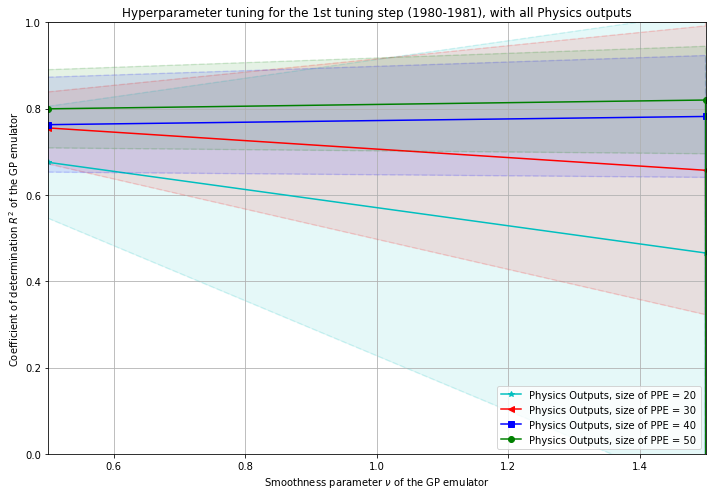

In [44]:
#figures 
labelPhyDyn=["Physics Outputs,", "Dynamics Outputs,"]

colors=['c','r','b','g','purple','orange']
linestyle=['-*','-<','-s','-o','-^','->']
#inddRealistic=np.where(abs(score_isize_2nd_mean[:,0,0])<1e10)[0] #remove runs that had a bug 
#print(inddRealistic)

plt.rcParams['figure.figsize'] = [10, 7]
plt.subplots()
ioutput=0
icol=0

for isimu in np.arange(len(sizeRes_2nd_allOut)):
    print(isimu)
    #for isimu in np.arange(np.len(score_nu_mean)-3,np.len(score_nu_mean)):
    plt.plot(inu,score_nu_mean[isimu,:],linestyle[isimu],\
                color=colors[isimu],label=labelPhyDyn[ioutput]+' size of PPE = '+str(sizeRes_2nd_allOut[isimu]))
                #', alpha = '+str(simuhyperparam[isimu][1])+', n_restart = '+str(simuhyperparam[isimu][2]))
    plt.plot(inu,score_nu_mean[isimu,:]+score_nu_std[isimu,:],'--',\
                color=colors[isimu],alpha=0.1)
    plt.plot(inu,score_nu_mean[isimu,:]-score_nu_std[isimu,:],'--',\
                color=colors[isimu],alpha=0.1)
    plt.fill_between(inu[:],score_nu_mean[isimu,:]-score_nu_std[isimu,:],score_nu_mean[isimu,:]+score_nu_std[isimu,:],\
                            color=colors[isimu],alpha=0.1)


plt.xlim(0.5,1.5,3)
#plt.xticks([0.5,1.5,3],labels=["0.5","1.5","inf"])
plt.ylim(0,1)
#plt.yticks(np.arange(0,1,0.1))
plt.title('Hyperparameter tuning for the 1st tuning step (1980-1981), with all Physics outputs')
plt.legend(loc='lower right')
plt.ylabel(r'Coefficient of determination $R^2$ of the GP emulator')
plt.xlabel(r'Smoothness parameter $\nu$ of the GP emulator')
plt.grid()
plt.tight_layout()
#plt.savefig("PaperFig/Performance_Emulator_wrt_Hyperparameters_1sttuningStep_nu.png")

In [74]:
#hyperparameter tuning : effect of alpha
varr=np.concatenate((var1stPPE,var2ndPPE),axis=0)
ress=np.concatenate((results1stPPE,results2ndPPE),axis=0) #phy

# train the GP on the training sample
ialp=[1e-5,1e-6,1e-7,1e-8,1e-9,1e-10] #nu, alpha, nrestart
Nsimu=len(ialp)
Nrand=20 # number of times we pick a sample of a given size
#for irand in np.arange(0,Nrand): repeat 5 times
totind=range(0,len(varr))
sizetest=8
sizetottrain=len(varr)-sizetest
minsizetrain=62
print(sizetottrain)
sizeRes_2nd_allOut=[20,30,40,50] #np.arange(minsizetrain,sizetottrain,1)

score_isize_2nd_allOut=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu,Nrand))
score_alp_mean=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu))
score_alp_std=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu))

isimu=0
for alp in ialp:
    for irand in range(Nrand):
        indtest=random.sample(totind,sizetest) #test set to remove from beginning
        scaler_var = preprocessing.StandardScaler().fit(varr)#[indtest])
        scaled_test = scaler_var.transform(varr[indtest]) 

        notindtest=[x for x in totind if x not in indtest] #all indices except the test indices
        indsam={}
        indSi=0
        for Sizz in sizeRes_2nd_allOut:
            print(Sizz)
            indtrain=random.sample(notindtest,Sizz) #train indices
            indsam[irand]=indtrain
            
            #scaler_var = preprocessing.StandardScaler().fit(varr[indtrain])
            scaled_train= scaler_var.transform(varr[indtrain])
            print('coucou',', irand ',irand,', isimu ', isimu, ', iSizz',Sizz)#,scaled_train) #indSi,indtrain,varr[indtrain],ress[indtrain])
            #scores=gaussian_process_multi.score( scaled_test, ress[indtest]) #scaled_train, ress[indtrain])#
            kernel = 1 * Matern(length_scale=1.0)#, nu=nuu) 

            gaussian_process_multi = GaussianProcessRegressor(kernel=kernel,alpha=alp)#, n_restarts_optimizer=n_ress)
            resstrain=ress[indtrain]
            resstest=ress[indtest]
            gaussian_process_multi.fit(scaled_train, resstrain) #
            gaussian_process_multi.kernel_

            scores=gaussian_process_multi.score(scaled_test, resstest) #
            print('aft fit', np.mean(scores))
            print(gaussian_process_multi.kernel_)
            
            score_isize_2nd_allOut[indSi,isimu,irand]=np.mean(scores)
            #randsamples_1st[Sizz]=indsam
            indSi+=1
    indSi=0
    for Sizz in sizeRes_2nd_allOut:    
        score_alp_mean[indSi,isimu]=np.mean(score_isize_2nd_allOut[indSi,isimu,:])
        score_alp_std[indSi,isimu]=np.std(score_isize_2nd_allOut[indSi,isimu,:])
        indSi+=1
    isimu+=1
#duration approx 20sec

51
20
coucou , irand  0 , isimu  0 , iSizz 20
aft fit 0.6862345811258306
97.7**2 * Matern(length_scale=66.6, nu=1.5)
30
coucou , irand  0 , isimu  0 , iSizz 30
aft fit 0.7514144815062476
101**2 * Matern(length_scale=54.1, nu=1.5)
40
coucou , irand  0 , isimu  0 , iSizz 40
aft fit 0.8432968100826512
95**2 * Matern(length_scale=55.2, nu=1.5)
50
coucou , irand  0 , isimu  0 , iSizz 50
aft fit 0.9044442022872715
98.9**2 * Matern(length_scale=51.9, nu=1.5)
20
coucou , irand  1 , isimu  0 , iSizz 20
aft fit 0.7564339067165655
98.2**2 * Matern(length_scale=74.2, nu=1.5)
30
coucou , irand  1 , isimu  0 , iSizz 30
aft fit 0.3981795704219321
99.5**2 * Matern(length_scale=58.6, nu=1.5)
40
coucou , irand  1 , isimu  0 , iSizz 40
aft fit 0.7432921167247193
97.5**2 * Matern(length_scale=54.5, nu=1.5)
50
coucou , irand  1 , isimu  0 , iSizz 50
aft fit 0.6915762070306601
101**2 * Matern(length_scale=53.6, nu=1.5)
20
coucou , irand  2 , isimu  0 , iSizz 20
aft fit 0.7398755477280947
99.9**2 * Matern(le

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7479977915275645
99.1**2 * Matern(length_scale=50.1, nu=1.5)
50
coucou , irand  10 , isimu  1 , iSizz 50
aft fit 0.8320198997684898
101**2 * Matern(length_scale=52.7, nu=1.5)
20
coucou , irand  11 , isimu  1 , iSizz 20
aft fit 0.13955637962747697
102**2 * Matern(length_scale=57.9, nu=1.5)
30
coucou , irand  11 , isimu  1 , iSizz 30
aft fit 0.7739042842451893
95.9**2 * Matern(length_scale=60.6, nu=1.5)
40
coucou , irand  11 , isimu  1 , iSizz 40
aft fit 0.8109600596063522
99.2**2 * Matern(length_scale=56, nu=1.5)
50
coucou , irand  11 , isimu  1 , iSizz 50
aft fit 0.7445780213329435
101**2 * Matern(length_scale=55, nu=1.5)
20
coucou , irand  12 , isimu  1 , iSizz 20
aft fit 0.41988408060764826
94.8**2 * Matern(length_scale=55, nu=1.5)
30
coucou , irand  12 , isimu  1 , iSizz 30
aft fit 0.8503863963187548
96.4**2 * Matern(length_scale=55.1, nu=1.5)
40
coucou , irand  12 , isimu  1 , iSizz 40
aft fit 0.8489824251977435
99.6**2 * Matern(length_scale=51.1, nu=1.5)
50
coucou , iran

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8199665576799757
99.9**2 * Matern(length_scale=51, nu=1.5)
20
coucou , irand  12 , isimu  2 , iSizz 20
aft fit 0.41310130831618996
97.1**2 * Matern(length_scale=52.1, nu=1.5)
30
coucou , irand  12 , isimu  2 , iSizz 30
aft fit 0.5115994208135296
95.6**2 * Matern(length_scale=49.3, nu=1.5)
40
coucou , irand  12 , isimu  2 , iSizz 40
aft fit 0.5768096095722866
102**2 * Matern(length_scale=61.3, nu=1.5)
50
coucou , irand  12 , isimu  2 , iSizz 50
aft fit 0.628099224931977
99.5**2 * Matern(length_scale=51.1, nu=1.5)
20
coucou , irand  13 , isimu  2 , iSizz 20
aft fit 0.7737325538030666
95.5**2 * Matern(length_scale=47.2, nu=1.5)
30
coucou , irand  13 , isimu  2 , iSizz 30
aft fit 0.7356302955278103
98.5**2 * Matern(length_scale=55.5, nu=1.5)
40
coucou , irand  13 , isimu  2 , iSizz 40
aft fit 0.9163576498833115
100**2 * Matern(length_scale=51.6, nu=1.5)
50
coucou , irand  13 , isimu  2 , iSizz 50
aft fit 0.8585147065113932
103**2 * Matern(length_scale=52.2, nu=1.5)
20
coucou , ir

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.6000182870162869
100**2 * Matern(length_scale=53.6, nu=1.5)
50
coucou , irand  8 , isimu  3 , iSizz 50
aft fit 0.7567822396351228
101**2 * Matern(length_scale=53.2, nu=1.5)
20
coucou , irand  9 , isimu  3 , iSizz 20
aft fit -0.03922384745190906
105**2 * Matern(length_scale=56.4, nu=1.5)
30
coucou , irand  9 , isimu  3 , iSizz 30
aft fit 0.5289845178516085
99.3**2 * Matern(length_scale=52.6, nu=1.5)
40
coucou , irand  9 , isimu  3 , iSizz 40
aft fit 0.7681530702977455
96.6**2 * Matern(length_scale=49.3, nu=1.5)
50
coucou , irand  9 , isimu  3 , iSizz 50
aft fit 0.7896355333926526
101**2 * Matern(length_scale=50.9, nu=1.5)
20
coucou , irand  10 , isimu  3 , iSizz 20
aft fit 0.685969004333624
98.5**2 * Matern(length_scale=63.3, nu=1.5)
30
coucou , irand  10 , isimu  3 , iSizz 30
aft fit 0.725314888775347
97.9**2 * Matern(length_scale=57.7, nu=1.5)
40
coucou , irand  10 , isimu  3 , iSizz 40
aft fit 0.8315711488118629
101**2 * Matern(length_scale=59.5, nu=1.5)
50
coucou , irand  

In [34]:
#hyperparameter tuning : effect of nrestart
varr=np.concatenate((var1stPPE,var2ndPPE),axis=0)
ress=np.concatenate((results1stPPE,results2ndPPE),axis=0) #phy

# train the GP on the training sample
inre=[0,1,5,10,20,50,100] #nu, alpha, nrestart
Nsimu=len(inre)
Nrand=10 # number of times we pick a sample of a given size
#for irand in np.arange(0,Nrand): repeat 5 times
totind=range(0,len(varr))
sizetest=8
sizetottrain=len(varr)-sizetest
minsizetrain=62
print(sizetottrain)
sizeRes_2nd_allOut=[20,30,40,50] #np.arange(minsizetrain,sizetottrain,1)

score_isize_2nd_allOut=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu,Nrand))
score_nre_mean=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu))
score_nre_std=np.zeros((np.size(sizeRes_2nd_allOut),Nsimu))

isimu=0
for nre in inre:
    for irand in range(Nrand):
        indtest=random.sample(totind,sizetest) #test set to remove from beginning
        scaler_var = preprocessing.StandardScaler().fit(varr)#[indtest])
        scaled_test = scaler_var.transform(varr[indtest]) 

        notindtest=[x for x in totind if x not in indtest] #all indices except the test indices
        indsam={}
        indSi=0
        for Sizz in sizeRes_2nd_allOut:
            print(Sizz)
            indtrain=random.sample(notindtest,Sizz) #train indices
            indsam[irand]=indtrain
            
            #scaler_var = preprocessing.StandardScaler().fit(varr[indtrain])
            scaled_train= scaler_var.transform(varr[indtrain])
            print('coucou',', irand ',irand,', isimu ', isimu, ', iSizz',Sizz)#,scaled_train) #indSi,indtrain,varr[indtrain],ress[indtrain])
            #scores=gaussian_process_multi.score( scaled_test, ress[indtest]) #scaled_train, ress[indtrain])#
            kernel = 1 * Matern(length_scale=1.0)#, nu=nuu) 

            gaussian_process_multi = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=nre)
            resstrain=ress[indtrain]
            resstest=ress[indtest]
            gaussian_process_multi.fit(scaled_train, resstrain) #
            gaussian_process_multi.kernel_

            scores=gaussian_process_multi.score(scaled_test, resstest) #
            print('aft fit', np.mean(scores))
            print(gaussian_process_multi.kernel_)
            
            score_isize_2nd_allOut[indSi,isimu,irand]=np.mean(scores)
            #randsamples_1st[Sizz]=indsam
            indSi+=1
    indSi=0
    for Sizz in sizeRes_2nd_allOut:    
        score_nre_mean[indSi,isimu]=np.mean(score_isize_2nd_allOut[indSi,isimu,:])
        score_nre_std[indSi,isimu]=np.std(score_isize_2nd_allOut[indSi,isimu,:])
        indSi+=1
    isimu+=1
#duration approx 2min

51
20
coucou , irand  0 , isimu  0 , iSizz 20
aft fit -0.3726921155836497
97.7**2 * Matern(length_scale=49.3, nu=1.5)
30
coucou , irand  0 , isimu  0 , iSizz 30
aft fit 0.6927920737262268
95.6**2 * Matern(length_scale=56.3, nu=1.5)
40
coucou , irand  0 , isimu  0 , iSizz 40
aft fit 0.7459071775375448
98**2 * Matern(length_scale=50.6, nu=1.5)
50
coucou , irand  0 , isimu  0 , iSizz 50
aft fit 0.8362196328707212
99**2 * Matern(length_scale=51.7, nu=1.5)
20
coucou , irand  1 , isimu  0 , iSizz 20
aft fit 0.49631068178406157
96.6**2 * Matern(length_scale=57.4, nu=1.5)
30
coucou , irand  1 , isimu  0 , iSizz 30
aft fit 0.5106091311454545
102**2 * Matern(length_scale=54.6, nu=1.5)
40
coucou , irand  1 , isimu  0 , iSizz 40
aft fit 0.7341823649772147
96.5**2 * Matern(length_scale=56.4, nu=1.5)
50
coucou , irand  1 , isimu  0 , iSizz 50
aft fit 0.847199093294716
102**2 * Matern(length_scale=54.8, nu=1.5)
20
coucou , irand  2 , isimu  0 , iSizz 20
aft fit 0.7918933760987746
97.2**2 * Matern(len

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.929043013213372
102**2 * Matern(length_scale=51.5, nu=1.5)
20
coucou , irand  4 , isimu  1 , iSizz 20
aft fit 0.7007491283926105
104**2 * Matern(length_scale=66.8, nu=1.5)
30
coucou , irand  4 , isimu  1 , iSizz 30
aft fit 0.8925263898429108
97.5**2 * Matern(length_scale=56.6, nu=1.5)
40
coucou , irand  4 , isimu  1 , iSizz 40
aft fit 0.7952209796135887
102**2 * Matern(length_scale=58.3, nu=1.5)
50
coucou , irand  4 , isimu  1 , iSizz 50
aft fit 0.908592712221816
103**2 * Matern(length_scale=55.1, nu=1.5)
20
coucou , irand  5 , isimu  1 , iSizz 20
aft fit 0.6942279412396458
99.2**2 * Matern(length_scale=49, nu=1.5)
30
coucou , irand  5 , isimu  1 , iSizz 30
aft fit 0.7843944065015656
94.5**2 * Matern(length_scale=50.6, nu=1.5)
40
coucou , irand  5 , isimu  1 , iSizz 40
aft fit 0.2714707206943759
103**2 * Matern(length_scale=54, nu=1.5)
50
coucou , irand  5 , isimu  1 , iSizz 50
aft fit 0.46787287940265393
102**2 * Matern(length_scale=52.1, nu=1.5)
20
coucou , irand  6 , isimu

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8638745496351271
98.2**2 * Matern(length_scale=51.9, nu=1.5)
50
coucou , irand  6 , isimu  1 , iSizz 50
aft fit 0.8923187841185964
100**2 * Matern(length_scale=52.3, nu=1.5)
20
coucou , irand  7 , isimu  1 , iSizz 20
aft fit -0.21618909287634996
103**2 * Matern(length_scale=56.2, nu=1.5)
30
coucou , irand  7 , isimu  1 , iSizz 30
aft fit 0.6580951366614258
94.4**2 * Matern(length_scale=52.8, nu=1.5)
40
coucou , irand  7 , isimu  1 , iSizz 40
aft fit 0.5893343170164987
99.9**2 * Matern(length_scale=52.8, nu=1.5)
50
coucou , irand  7 , isimu  1 , iSizz 50
aft fit 0.6570300775039132
101**2 * Matern(length_scale=54.2, nu=1.5)
20
coucou , irand  8 , isimu  1 , iSizz 20
aft fit 0.5949429467051937
93.8**2 * Matern(length_scale=54, nu=1.5)
30
coucou , irand  8 , isimu  1 , iSizz 30
aft fit 0.5818426516655031
94**2 * Matern(length_scale=53.6, nu=1.5)
40
coucou , irand  8 , isimu  1 , iSizz 40
aft fit 0.8073586147076828
100**2 * Matern(length_scale=54.2, nu=1.5)
50
coucou , irand  8 , 

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8125380733889053
95**2 * Matern(length_scale=63.3, nu=1.5)
40
coucou , irand  0 , isimu  2 , iSizz 40
aft fit 0.7780380763714883
100**2 * Matern(length_scale=52.4, nu=1.5)
50
coucou , irand  0 , isimu  2 , iSizz 50
aft fit 0.841214886663361
99.2**2 * Matern(length_scale=53.5, nu=1.5)
20
coucou , irand  1 , isimu  2 , iSizz 20
aft fit 0.778872902373301
99.6**2 * Matern(length_scale=55.6, nu=1.5)
30
coucou , irand  1 , isimu  2 , iSizz 30
aft fit 0.7387765888003024
94.6**2 * Matern(length_scale=50.7, nu=1.5)
40
coucou , irand  1 , isimu  2 , iSizz 40
aft fit 0.8363671081991644
101**2 * Matern(length_scale=57, nu=1.5)
50
coucou , irand  1 , isimu  2 , iSizz 50
aft fit 0.8634662558929775
98.4**2 * Matern(length_scale=50.7, nu=1.5)
20
coucou , irand  2 , isimu  2 , iSizz 20
aft fit 0.5625845487020126
103**2 * Matern(length_scale=65.4, nu=1.5)
30
coucou , irand  2 , isimu  2 , iSizz 30
aft fit 0.703185729619006
98.1**2 * Matern(length_scale=54.9, nu=1.5)
40
coucou , irand  2 , isim

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7590228545968107
101**2 * Matern(length_scale=51.8, nu=1.5)
20
coucou , irand  4 , isimu  3 , iSizz 20
aft fit -0.11406026422036594
99.1**2 * Matern(length_scale=50.4, nu=1.5)
30
coucou , irand  4 , isimu  3 , iSizz 30
aft fit 0.41404013376847343
97.4**2 * Matern(length_scale=49.7, nu=1.5)
40
coucou , irand  4 , isimu  3 , iSizz 40
aft fit 0.6604276813088326
101**2 * Matern(length_scale=56.9, nu=1.5)
50
coucou , irand  4 , isimu  3 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7763935891449286
101**2 * Matern(length_scale=51.1, nu=1.5)
20
coucou , irand  5 , isimu  3 , iSizz 20
aft fit 0.6345604145990336
95.2**2 * Matern(length_scale=62, nu=1.5)
30
coucou , irand  5 , isimu  3 , iSizz 30
aft fit 0.596635256205109
94.2**2 * Matern(length_scale=51.5, nu=1.5)
40
coucou , irand  5 , isimu  3 , iSizz 40


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8608561437647436
105**2 * Matern(length_scale=53.5, nu=1.5)
50
coucou , irand  5 , isimu  3 , iSizz 50
aft fit 0.8840938196632665
101**2 * Matern(length_scale=52.3, nu=1.5)
20
coucou , irand  6 , isimu  3 , iSizz 20
aft fit 0.5088792571656702
93.4**2 * Matern(length_scale=63.2, nu=1.5)
30
coucou , irand  6 , isimu  3 , iSizz 30
aft fit 0.8318356169734017
102**2 * Matern(length_scale=65.1, nu=1.5)
40
coucou , irand  6 , isimu  3 , iSizz 40
aft fit 0.7697521401639127
97.6**2 * Matern(length_scale=52.8, nu=1.5)
50
coucou , irand  6 , isimu  3 , iSizz 50
aft fit 0.8871619006500383
101**2 * Matern(length_scale=53.2, nu=1.5)
20
coucou , irand  7 , isimu  3 , iSizz 20
aft fit 0.5026005641449327
99.5**2 * Matern(length_scale=54.3, nu=1.5)
30
coucou , irand  7 , isimu  3 , iSizz 30
aft fit 0.6912775404870101
94.9**2 * Matern(length_scale=48.6, nu=1.5)
40
coucou , irand  7 , isimu  3 , iSizz 40
aft fit 0.748429728885119
95.6**2 * Matern(length_scale=50.7, nu=1.5)
50
coucou , irand  7 ,

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.6597490138395723
101**2 * Matern(length_scale=53, nu=1.5)
20
coucou , irand  3 , isimu  4 , iSizz 20


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7216160531986138
96.2**2 * Matern(length_scale=61.5, nu=1.5)
30
coucou , irand  3 , isimu  4 , iSizz 30
aft fit 0.9244970802564
98.5**2 * Matern(length_scale=56.1, nu=1.5)
40
coucou , irand  3 , isimu  4 , iSizz 40
aft fit 0.9431408481911527
101**2 * Matern(length_scale=56.3, nu=1.5)
50
coucou , irand  3 , isimu  4 , iSizz 50
aft fit 0.964520043061835
102**2 * Matern(length_scale=51.6, nu=1.5)
20
coucou , irand  4 , isimu  4 , iSizz 20
aft fit 0.5016669215291121
99.4**2 * Matern(length_scale=54.4, nu=1.5)
30
coucou , irand  4 , isimu  4 , iSizz 30
aft fit 0.7932588025619167
102**2 * Matern(length_scale=57.6, nu=1.5)
40
coucou , irand  4 , isimu  4 , iSizz 40


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.6089903064888519
101**2 * Matern(length_scale=55.9, nu=1.5)
50
coucou , irand  4 , isimu  4 , iSizz 50
aft fit 0.8136281238732044
101**2 * Matern(length_scale=53.1, nu=1.5)
20
coucou , irand  5 , isimu  4 , iSizz 20
aft fit 0.6972954051714809
95**2 * Matern(length_scale=57, nu=1.5)
30
coucou , irand  5 , isimu  4 , iSizz 30
aft fit 0.6485429735813952
101**2 * Matern(length_scale=58.1, nu=1.5)
40
coucou , irand  5 , isimu  4 , iSizz 40
aft fit 0.3961876613945031
100**2 * Matern(length_scale=54.3, nu=1.5)
50
coucou , irand  5 , isimu  4 , iSizz 50
aft fit 0.3154699263191666
103**2 * Matern(length_scale=52.1, nu=1.5)
20
coucou , irand  6 , isimu  4 , iSizz 20
aft fit 0.8657095769084047
93.5**2 * Matern(length_scale=53.5, nu=1.5)
30
coucou , irand  6 , isimu  4 , iSizz 30
aft fit 0.8535581336816996
94.2**2 * Matern(length_scale=51.8, nu=1.5)
40
coucou , irand  6 , isimu  4 , iSizz 40
aft fit 0.8787415447651327
99.3**2 * Matern(length_scale=53.1, nu=1.5)
50
coucou , irand  6 , isi

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit -0.04215272560955785
103**2 * Matern(length_scale=58.7, nu=1.5)
30
coucou , irand  0 , isimu  5 , iSizz 30
aft fit 0.7647620763094508
97.7**2 * Matern(length_scale=49.7, nu=1.5)
40
coucou , irand  0 , isimu  5 , iSizz 40


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8525277925237635
101**2 * Matern(length_scale=49, nu=1.5)
50
coucou , irand  0 , isimu  5 , iSizz 50
aft fit 0.9217923002079633
102**2 * Matern(length_scale=51, nu=1.5)
20
coucou , irand  1 , isimu  5 , iSizz 20
aft fit 0.9282016923554893
99.1**2 * Matern(length_scale=63.9, nu=1.5)
30
coucou , irand  1 , isimu  5 , iSizz 30


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8827660618574467
100**2 * Matern(length_scale=51.8, nu=1.5)
40
coucou , irand  1 , isimu  5 , iSizz 40
aft fit 0.9267556647383666
99.5**2 * Matern(length_scale=54.9, nu=1.5)
50
coucou , irand  1 , isimu  5 , iSizz 50
aft fit 0.930419246031429
101**2 * Matern(length_scale=52.6, nu=1.5)
20
coucou , irand  2 , isimu  5 , iSizz 20
aft fit 0.8134761044748394
93.5**2 * Matern(length_scale=62, nu=1.5)
30
coucou , irand  2 , isimu  5 , iSizz 30
aft fit 0.9286393883663934
96**2 * Matern(length_scale=54, nu=1.5)
40
coucou , irand  2 , isimu  5 , iSizz 40
aft fit 0.8531179961948976
104**2 * Matern(length_scale=55.4, nu=1.5)
50
coucou , irand  2 , isimu  5 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.9243021436818539
103**2 * Matern(length_scale=53.5, nu=1.5)
20
coucou , irand  3 , isimu  5 , iSizz 20
aft fit -0.07903927717543166
104**2 * Matern(length_scale=64.4, nu=1.5)
30
coucou , irand  3 , isimu  5 , iSizz 30
aft fit 0.712098448636008
98.1**2 * Matern(length_scale=54.1, nu=1.5)
40
coucou , irand  3 , isimu  5 , iSizz 40


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7881465014860147
98.9**2 * Matern(length_scale=55.6, nu=1.5)
50
coucou , irand  3 , isimu  5 , iSizz 50
aft fit 0.8214379627062065
101**2 * Matern(length_scale=54.5, nu=1.5)
20
coucou , irand  4 , isimu  5 , iSizz 20
aft fit 0.4684189998351922
95.3**2 * Matern(length_scale=58.3, nu=1.5)
30
coucou , irand  4 , isimu  5 , iSizz 30
aft fit 0.42444884229291835
97.3**2 * Matern(length_scale=55.9, nu=1.5)
40
coucou , irand  4 , isimu  5 , iSizz 40
aft fit 0.7653820726762549
99.3**2 * Matern(length_scale=49.4, nu=1.5)
50
coucou , irand  4 , isimu  5 , iSizz 50
aft fit 0.701007481076269
99.8**2 * Matern(length_scale=51.8, nu=1.5)
20
coucou , irand  5 , isimu  5 , iSizz 20
aft fit 0.3470994014058685
97**2 * Matern(length_scale=44.4, nu=1.5)
30
coucou , irand  5 , isimu  5 , iSizz 30
aft fit 0.6121416887278948
96.9**2 * Matern(length_scale=62.2, nu=1.5)
40
coucou , irand  5 , isimu  5 , iSizz 40
aft fit 0.6136404724919283
102**2 * Matern(length_scale=53.5, nu=1.5)
50
coucou , irand  5 

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7383573866764872
99.7**2 * Matern(length_scale=59.3, nu=1.5)
40
coucou , irand  6 , isimu  5 , iSizz 40
aft fit 0.8615349583638607
103**2 * Matern(length_scale=53.1, nu=1.5)
50
coucou , irand  6 , isimu  5 , iSizz 50
aft fit 0.881624082842445
103**2 * Matern(length_scale=54.7, nu=1.5)
20
coucou , irand  7 , isimu  5 , iSizz 20


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.43133645291645345
99.7**2 * Matern(length_scale=69.3, nu=1.5)
30
coucou , irand  7 , isimu  5 , iSizz 30
aft fit 0.37144719939402293
96.4**2 * Matern(length_scale=54.7, nu=1.5)
40
coucou , irand  7 , isimu  5 , iSizz 40


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.3258722135413022
101**2 * Matern(length_scale=53.1, nu=1.5)
50
coucou , irand  7 , isimu  5 , iSizz 50
aft fit 0.049424615629611465
101**2 * Matern(length_scale=52, nu=1.5)
20
coucou , irand  8 , isimu  5 , iSizz 20
aft fit 0.8871595568749729
97.3**2 * Matern(length_scale=56.1, nu=1.5)
30
coucou , irand  8 , isimu  5 , iSizz 30
aft fit 0.8728955889981679
98.5**2 * Matern(length_scale=59, nu=1.5)
40
coucou , irand  8 , isimu  5 , iSizz 40
aft fit 0.9391377772601667
101**2 * Matern(length_scale=52, nu=1.5)
50
coucou , irand  8 , isimu  5 , iSizz 50
aft fit 0.9491156373509648
101**2 * Matern(length_scale=52.4, nu=1.5)
20
coucou , irand  9 , isimu  5 , iSizz 20
aft fit 0.792740065846739
94.4**2 * Matern(length_scale=52.5, nu=1.5)
30
coucou , irand  9 , isimu  5 , iSizz 30
aft fit 0.8497918942217814
97.4**2 * Matern(length_scale=53.7, nu=1.5)
40
coucou , irand  9 , isimu  5 , iSizz 40
aft fit 0.9168795428980987
99.7**2 * Matern(length_scale=52.4, nu=1.5)
50
coucou , irand  9 , isi

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit -0.2803056679219201
98.1**2 * Matern(length_scale=60.4, nu=1.5)
30
coucou , irand  1 , isimu  6 , iSizz 30
aft fit 0.4381928751608843
98.2**2 * Matern(length_scale=55.7, nu=1.5)
40
coucou , irand  1 , isimu  6 , iSizz 40
aft fit 0.6992818595024917
97.7**2 * Matern(length_scale=51.8, nu=1.5)
50
coucou , irand  1 , isimu  6 , iSizz 50
aft fit 0.620803371223485
99.8**2 * Matern(length_scale=52.2, nu=1.5)
20
coucou , irand  2 , isimu  6 , iSizz 20
aft fit 0.7831902302233867
95.6**2 * Matern(length_scale=56.6, nu=1.5)
30
coucou , irand  2 , isimu  6 , iSizz 30
aft fit 0.8272279102655627
96.3**2 * Matern(length_scale=58.2, nu=1.5)
40
coucou , irand  2 , isimu  6 , iSizz 40
aft fit 0.8661413848837853
98.8**2 * Matern(length_scale=52.2, nu=1.5)
50
coucou , irand  2 , isimu  6 , iSizz 50
aft fit 0.9175520149089461
99.8**2 * Matern(length_scale=50.3, nu=1.5)
20
coucou , irand  3 , isimu  6 , iSizz 20


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8019715426682239
96.2**2 * Matern(length_scale=50.4, nu=1.5)
30
coucou , irand  3 , isimu  6 , iSizz 30


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.8371121339199622
100**2 * Matern(length_scale=49.1, nu=1.5)
40
coucou , irand  3 , isimu  6 , iSizz 40


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.7826189799815405
100**2 * Matern(length_scale=53.3, nu=1.5)
50
coucou , irand  3 , isimu  6 , iSizz 50
aft fit 0.8587481625559727
101**2 * Matern(length_scale=55.2, nu=1.5)
20
coucou , irand  4 , isimu  6 , iSizz 20
aft fit 0.15491503508041815
92.3**2 * Matern(length_scale=57.2, nu=1.5)
30
coucou , irand  4 , isimu  6 , iSizz 30
aft fit 0.20335450980060593
95.6**2 * Matern(length_scale=54.3, nu=1.5)
40
coucou , irand  4 , isimu  6 , iSizz 40


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit -0.3235623805097848
99.2**2 * Matern(length_scale=54.2, nu=1.5)
50
coucou , irand  4 , isimu  6 , iSizz 50


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.1703105367776015
102**2 * Matern(length_scale=56.9, nu=1.5)
20
coucou , irand  5 , isimu  6 , iSizz 20


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.45680175740070544
97.6**2 * Matern(length_scale=49, nu=1.5)
30
coucou , irand  5 , isimu  6 , iSizz 30
aft fit 0.5401430959763045
96.6**2 * Matern(length_scale=59.2, nu=1.5)
40
coucou , irand  5 , isimu  6 , iSizz 40
aft fit 0.5592215144822978
96.4**2 * Matern(length_scale=53, nu=1.5)
50
coucou , irand  5 , isimu  6 , iSizz 50
aft fit 0.5832595007961607
101**2 * Matern(length_scale=53.3, nu=1.5)
20
coucou , irand  6 , isimu  6 , iSizz 20
aft fit 0.6386547318385529
99.5**2 * Matern(length_scale=54, nu=1.5)
30
coucou , irand  6 , isimu  6 , iSizz 30
aft fit 0.7141864163774774
100**2 * Matern(length_scale=50.1, nu=1.5)
40
coucou , irand  6 , isimu  6 , iSizz 40
aft fit 0.9103179845076703
98.5**2 * Matern(length_scale=50.2, nu=1.5)
50
coucou , irand  6 , isimu  6 , iSizz 50
aft fit 0.8920892397694367
101**2 * Matern(length_scale=50.3, nu=1.5)
20
coucou , irand  7 , isimu  6 , iSizz 20
aft fit 0.5701685122598731
92.5**2 * Matern(length_scale=53.8, nu=1.5)
30
coucou , irand  7 , is

/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


aft fit 0.6437742072288776
102**2 * Matern(length_scale=61.1, nu=1.5)
40
coucou , irand  9 , isimu  6 , iSizz 40
aft fit 0.5961401479660011
103**2 * Matern(length_scale=59.6, nu=1.5)
50
coucou , irand  9 , isimu  6 , iSizz 50
aft fit 0.6189463876391048
103**2 * Matern(length_scale=54.7, nu=1.5)


0
1
2
3
0
1
2
3
0
1
2
3


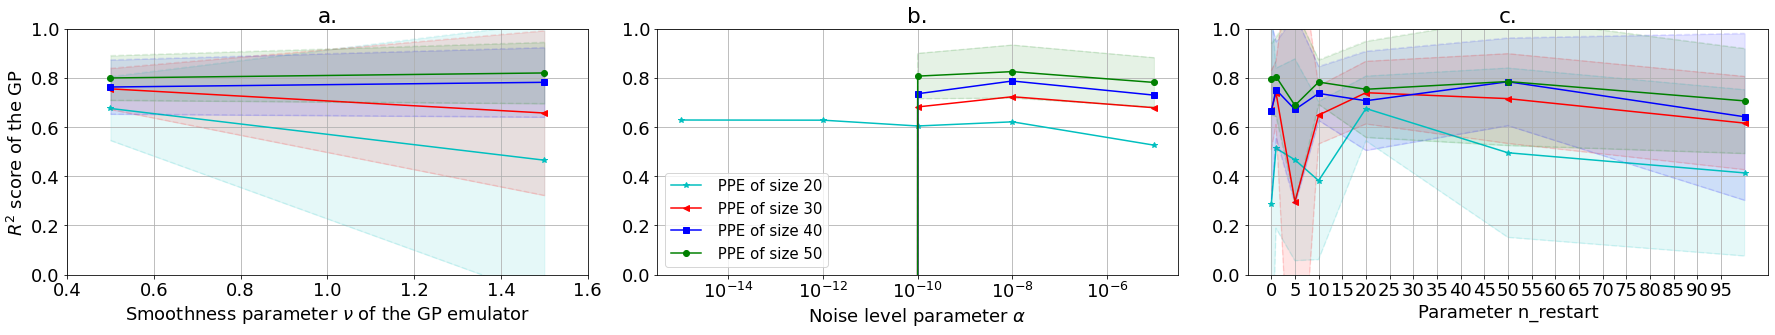

In [73]:
#all hyperparameters in one subplot

#figures 

labelPhyDyn=["Physics Outputs,", "Dynamics Outputs,"]

colors=['c','r','b','g','purple','orange']
linestyle=['-*','-<','-s','-o','-^','->']
#inddRealistic=np.where(abs(score_isize_2nd_mean[:,0,0])<1e10)[0] #remove runs that had a bug 
#print(inddRealistic)

plt.rcParams['figure.figsize'] = [25, 5]
plt.rcParams["legend.fontsize"] = 15
plt.rcParams.update({'font.size': 18})
ioutput=0
icol=0

fig, axs = plt.subplots(3, sharey=True)
plt.subplot(1,3,1)
Nnu=2
for isimu in np.arange(len(sizeRes_2nd_allOut)):
    print(isimu)
    #for isimu in np.arange(np.len(score_nu_mean)-3,np.len(score_nu_mean)):
    plt.plot(inu[:Nnu],score_nu_mean[isimu,:Nnu],linestyle[isimu],\
                color=colors[isimu],label=' PPE of size '+str(sizeRes_2nd_allOut[isimu]))
                #', alpha = '+str(simuhyperparam[isimu][1])+', n_restart = '+str(simuhyperparam[isimu][2]))
    plt.plot(inu[:Nnu],score_nu_mean[isimu,:Nnu]+score_nu_std[isimu,:Nnu],'--',\
                color=colors[isimu],alpha=0.1)
    plt.plot(inu[:Nnu],score_nu_mean[isimu,:Nnu]-score_nu_std[isimu,:Nnu],'--',\
                color=colors[isimu],alpha=0.1)
    plt.fill_between(inu[:Nnu],score_nu_mean[isimu,:Nnu]-score_nu_std[isimu,:Nnu],score_nu_mean[isimu,:Nnu]+score_nu_std[isimu,:Nnu],\
                            color=colors[isimu],alpha=0.1)


plt.xlim(0.4,1.6)
#plt.xticks([0.5,1.5,3],labels=["0.5","1.5","inf"])
plt.ylim(0,1)
#plt.yticks(np.arange(0,1,0.1))
plt.title('a.')
#plt.legend(loc='lower right')
plt.ylabel(r'$R^2$ score of the GP')
plt.xlabel(r'Smoothness parameter $\nu$ of the GP emulator')
plt.grid()
plt.tight_layout()

plt.subplot(1,3,2)
for isimu in np.arange(len(sizeRes_2nd_allOut)):
    print(isimu)
    #for isimu in np.arange(np.len(score_nu_mean)-3,np.len(score_nu_mean)):
    plt.semilogx(ialp,score_alp_mean[isimu,:],linestyle[isimu],\
                color=colors[isimu],label=' PPE of size '+str(sizeRes_2nd_allOut[isimu]))
                #', alpha = '+str(simuhyperparam[isimu][1])+', n_restart = '+str(simuhyperparam[isimu][2]))
plt.semilogx(ialp,score_alp_mean[isimu,:]+score_alp_std[isimu,:],'--',\
                color=colors[isimu],alpha=0.1)
plt.semilogx(ialp,score_alp_mean[isimu,:]-score_alp_std[isimu,:],'--',\
                color=colors[isimu],alpha=0.1)
plt.fill_between(ialp[:],score_alp_mean[isimu,:]-score_alp_std[isimu,:],score_alp_mean[isimu,:]+score_alp_std[isimu,:],\
                            color=colors[isimu],alpha=0.1)


#plt.xlim(-1e-10,1e-5)
plt.ylim(0.,1)
#plt.yticks(np.arange(0,1,0.1))
plt.title('b.')
plt.legend(loc='lower left')
#plt.ylabel(r'Coefficient of determination $R^2$ of the GP emulator')
plt.xlabel(r'Noise level parameter $\alpha$')
plt.grid()
plt.tight_layout()

plt.subplot(1,3,3)
for isimu in np.arange(len(sizeRes_2nd_allOut)):
    print(isimu)
    #for isimu in np.arange(np.len(score_nu_mean)-3,np.len(score_nu_mean)):
    plt.plot(inre,score_nre_mean[isimu,:],linestyle[isimu],\
                color=colors[isimu],label=' PPE of size '+str(sizeRes_2nd_allOut[isimu]))
                #', alpha = '+str(simuhyperparam[isimu][1])+', n_restart = '+str(simuhyperparam[isimu][2]))
    plt.plot(inre,score_nre_mean[isimu,:]+score_nre_std[isimu,:],'--',color=colors[isimu],alpha=0.1)
    plt.plot(inre,score_nre_mean[isimu,:]-score_nre_std[isimu,:],'--',color=colors[isimu],alpha=0.1)
    plt.fill_between(inre[:],score_nre_mean[isimu,:]-score_nre_std[isimu,:],score_nre_mean[isimu,:]+score_nre_std[isimu,:],\
                            color=colors[isimu],alpha=0.1)

plt.xlim(-1e-10,1e-5)
plt.ylim(0.,1)
plt.xticks(np.arange(0,100,5))
plt.title('c.')
#plt.legend(loc='lower right')
#plt.ylabel(r'Coefficient of determination $R^2$ of the GP emulator')
plt.xlabel('Parameter n_restart')# on the hyperparameter search')
plt.grid()
plt.tight_layout()

#plt.savefig("PaperFig/Performance_Emulator_wrt_Hyperparameters_1sttuningStep_nu_alpha_nre_subplots.png")

# Sobol and Morris indices for Paper

In [5]:
#define all GP 

def GPfunc(varr,ress):
    ### train the GP on the training sample PhyDyn only on the Physics outputs, all parameters 
    kernel = 1 * Matern(length_scale=1.0, nu=1.5) #RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) #np.array([1.0,1.0,1.0])) #length_scale=10) # ,1.0,1.0,1.0]))#, length_scale_bounds=(1e-2, 1e2))
    GP_multi = GaussianProcessRegressor(kernel=kernel,alpha=1e-5, n_restarts_optimizer=20)
    #scale data https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
    scaler_var1_2tun_allPar = preprocessing.StandardScaler().fit(varr[:,:],)
    scaled_var1_2tun_allPar = scaler_var1_2tun_allPar.transform(varr[:,:])
    print(ress)
    GP_multi.fit(scaled_var1_2tun_allPar, ress) #results_dyn_2tun_psltauuNAOSSO #results_all_2tun) #
    GP_multi.kernel_
    return GP_multi, np.min(scaled_var1_2tun_allPar),np.max(scaled_var1_2tun_allPar)


In [6]:
#change if needed:

GP_1,minn1,maxx1=GPfunc(var1stPPE,results1stPPE)
GP_1_2,minn12,maxx12=GPfunc(np.concatenate((var1stPPE,var2ndPPE),axis=0),np.concatenate((results1stPPE,results2ndPPE),axis=0))
GP_3,minn3,maxx3=GPfunc(varMoreCloudParam,resultsMoreCloudParam)
GP_3_4,minn34,maxx34=GPfunc(np.concatenate((varMoreCloudParam,varMoreCloudParam2),axis=0),np.concatenate((resultsMoreCloudParam,resultsMoreCloudParam2),axis=0))

def func_GP_for_Sobol1(input,ioutput):
 mean_output,_=GP_1.predict(input, return_std=True)
 return mean_output[:,ioutput]

def func_GP_for_Sobol12(input,ioutput):
 mean_output,_=GP_1_2.predict(input, return_std=True)
 return mean_output[:,ioutput]

def func_GP_for_Sobol3(input,ioutput):
 mean_output,_=GP_3.predict(input, return_std=True)
 return mean_output[:,ioutput]

def func_GP_for_Sobol34(input,ioutput):
 mean_output,_=GP_3_4.predict(input, return_std=True)
 return mean_output[:,ioutput]

[[ 2.355353e+02 -2.402893e+02 -4.754000e+00  6.151930e+01  2.392470e+01]
 [ 2.390479e+02 -2.410885e+02 -2.040600e+00  6.031800e+01  2.487590e+01]
 [ 2.476794e+02 -2.409854e+02  6.694000e+00  5.786150e+01  2.337110e+01]
 [ 2.385621e+02 -2.407213e+02 -2.159200e+00  6.049450e+01  2.403240e+01]
 [ 2.409524e+02 -2.419270e+02 -9.746000e-01  5.946250e+01  2.391820e+01]
 [ 2.444030e+02 -2.410450e+02  3.358000e+00  5.815050e+01  2.366440e+01]
 [ 2.387598e+02 -2.398128e+02 -1.053000e+00  6.111100e+01  2.430250e+01]
 [ 2.424295e+02 -2.418592e+02  5.703000e-01  5.876870e+01  2.399060e+01]
 [ 2.416968e+02 -2.409878e+02  7.090000e-01  5.903820e+01  2.372740e+01]
 [ 2.421809e+02 -2.404481e+02  1.732800e+00  6.031000e+01  2.448630e+01]
 [ 2.425088e+02 -2.424236e+02  8.520000e-02  5.875090e+01  2.476900e+01]
 [ 2.399867e+02 -2.408773e+02 -8.906000e-01  6.000910e+01  2.451710e+01]
 [ 2.371731e+02 -2.397560e+02 -2.582900e+00  6.085590e+01  2.273220e+01]
 [ 2.438572e+02 -2.403821e+02  3.475100e+00  5.9508

In [9]:
# calculate the sensitivity indices for this GP PPE
# code taken from https://gist.github.com/tupui/09f065d6afc923d4c2f5d6d430e11696
# 1st order Sobol indices S1 : tab 2.b / var(f(A), f(B)) of https://doi.org/10.1016/j.cpc.2009.09.018
# Total order Sobol indices St : tab 2.f / var(f(A), f(B)) of https://doi.org/10.1016/j.cpc.2009.09.018
def sobol_original(func, minn,maxx,n_sample, diminput, noutputs,bounds=None, seed=None):
    """Sobol' indices.
    The total number of function call is N(p+2).
    Three matrices are required for the computation of
    the indices: A, B and a permutation matrix AB based
    on both A and B.
    :param callable func: Function to analyse.
    :param int n_sample: Number of samples.
    :param int dim: Number of dimensions.
    :param array_like bounds: Desired range of transformed data.
      The transformation apply the bounds on the sample and not
      the theoretical space, unit cube. Thus min and
      max values of the sample will coincide with the bounds.
      ([min, n_features], [max, n_features]).
    :param seed: Seed of the random number generator.
    :return: first orders and total orders indices.
    :rtype: list(float) (n_features), list(float) (n_features)
    """
    rng = np.random.default_rng(seed)
    A = rng.random((n_sample, diminput))
    B = rng.random((n_sample, diminput))
    s_all={}
    st_all={}
    # if bounds is not None:
    bounds=[[minn*np.ones(diminput)], [maxx*np.ones(diminput)]]
    bounds = np.asarray(bounds)
    min_ = bounds.min(axis=0)
    max_ = bounds.max(axis=0)

    A = (max_ - min_) * A + min_
    B = (max_ - min_) * B + min_
    for ioutput in np.arange(noutputs):
      f_A = func(A,ioutput)
      f_B = func(B,ioutput)
      var = np.var(np.vstack([f_A, f_B]))
      
      f_AB = []
      for i in range(diminput):
          f_AB.append(func(np.column_stack((A[:, 0:i], B[:, i], A[:, i+1:])),ioutput))
          
      f_AB = np.array(f_AB).reshape(diminput, n_sample)
      s = 1 / n_sample * np.sum(f_B * np.subtract(f_AB,f_A.flatten()), axis=1) #/ var
      st = 1 / (2 * n_sample) * np.sum(np.subtract(f_A.flatten(), f_AB).T ** 2, axis=0) #/ var
      s_all[ioutput]=s
      st_all[ioutput]=st

    return s_all, st_all

In [10]:
#1st, 2nd, 4rd, 5th paper PPEs
minnall=[minn1,minn12,minn3,minn34]
maxxall=[maxx1,maxx12,maxx3,maxx34]
icase=0
indicesall={}
nparam=[6,6,7,7]
noutputs=5 #number of outputs
for funcc in [func_GP_for_Sobol1,func_GP_for_Sobol12,func_GP_for_Sobol3,func_GP_for_Sobol34]:
    print('icase',icase)
    indices = sobol_original(funcc,minnall[icase],maxxall[icase],70000,nparam[icase], noutputs)
    for ioutput in np.arange(noutputs):
        print('output',ioutput)
        for iparam in np.arange(nparam[icase]):
            print('parameter', iparam,'has a first order Sobol indice of',  round(indices[0][ioutput][iparam], 2), 'and total Sobol indice of', round(indices[1][ioutput][iparam], 2))
    indicesall[icase]=indices
    icase+=1

icase 0
output 0
parameter 0 has a first order Sobol indice of 1.7 and total Sobol indice of 0.61
parameter 1 has a first order Sobol indice of 2.82 and total Sobol indice of 2.57
parameter 2 has a first order Sobol indice of -0.47 and total Sobol indice of 0.28
parameter 3 has a first order Sobol indice of 1.37 and total Sobol indice of 0.47
parameter 4 has a first order Sobol indice of 0.37 and total Sobol indice of 0.6
parameter 5 has a first order Sobol indice of 2.67 and total Sobol indice of 8.57
output 1
parameter 0 has a first order Sobol indice of 0.2 and total Sobol indice of 0.01
parameter 1 has a first order Sobol indice of 0.2 and total Sobol indice of 0.23
parameter 2 has a first order Sobol indice of -0.15 and total Sobol indice of 0.02
parameter 3 has a first order Sobol indice of -0.0 and total Sobol indice of 0.01
parameter 4 has a first order Sobol indice of -0.26 and total Sobol indice of 0.09
parameter 5 has a first order Sobol indice of -0.77 and total Sobol indic

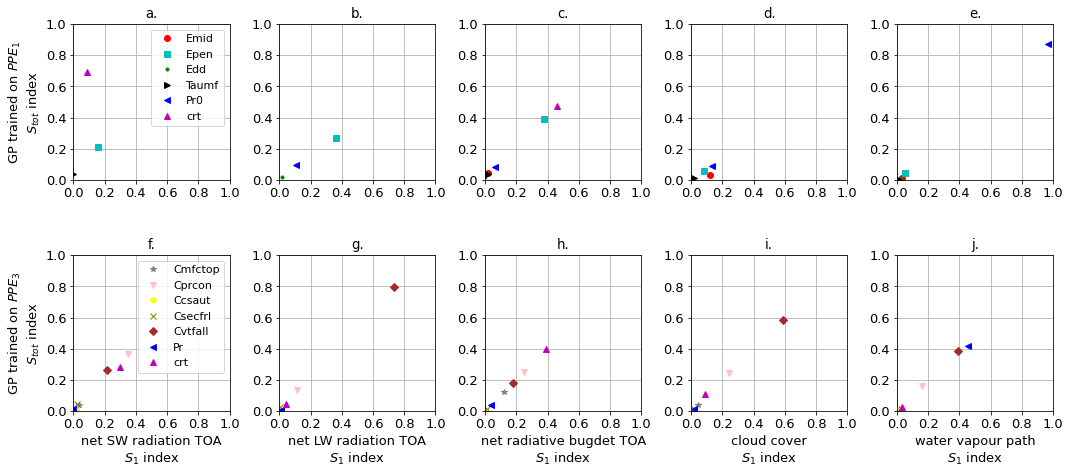

In [34]:
names_metrics=['net SW radiation TOA', 'net LW radiation TOA', 'net radiative bugdet TOA',  'cloud cover','water vapour path']#,'tauu on NAO','tauu on SOO','ua at 60N and 10hPa','ua at 60S and 10hPa']
parameters_list1 =['Emid','Epen','Edd','Taumf', 'Pr0', 'crt']
colors1=['r','c','g','k','b','m']
shapes1=['o','s','.','>','<','^']
parameters_list2=['Cmfctop', 'Cprcon', 'Ccsaut', 'Csecfrl', 'Cvtfall', 'Pr', 'crt']
colors2=['gray','pink','yellow','olive','brown', 'b','m']
shapes2=['*','v','p','x','D', '<','^']
leg_case=[r'$PPE_1$',r'$PPE_1$ and $PPE_2$',r'$PPE_3$',r'$PPE_3$ and $PPE_4$']
letter=['a.','b.','c.','d.','e.','f.','g.','h.','i.','j.']
fontsize=13
plt.rc('font', size=fontsize-2) 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['figure.figsize'] = [15, 8]

fig = plt.figure()
#fig.patch.set_facecolor('white')
nparam=[6,6,7,7]  
iplot=0
ncase=4
for icase in [0,2]: #only PPE1 and PPE3
    if (icase==0 or icase==1):
        param=parameters_list1
        col=colors1
        sha=shapes1
    if (icase==2 or icase==3):
        param=parameters_list2
        col=colors2
        sha=shapes2
    for ioutput in np.arange(noutputs):# 5 outputs
        ax = fig.add_subplot(2,5,iplot+1)
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.xticks(np.arange(0,1.1,0.2))
        ax.set_aspect('equal')
        for iparam in np.arange(nparam[icase]):
            plt.plot(indicesall[icase][0][ioutput][iparam],indicesall[icase][1][ioutput][iparam],sha[iparam],color=col[iparam],label=param[iparam])
        if iplot in np.arange(0,ncase*noutputs-1,noutput):
            plt.legend()
            plt.ylabel(r'GP trained on '+leg_case[icase]+'\n'+r'$S_{tot}$ index')   
        #else:
        #    plt.yticks(color='w')     
        #if icase==0:
        #    plt.xticks(color='w')     
        if icase==2 :
            plt.xlabel(names_metrics[ioutput]+'\n'+r'$S_1$ index')    
        
        plt.title(letter[iplot])
        plt.grid()
        iplot+=1
        fig.tight_layout()
#plt.savefig('PaperFig/all_Sobol_indices_PhysicsOutputs_PPE1_PPE3.png')

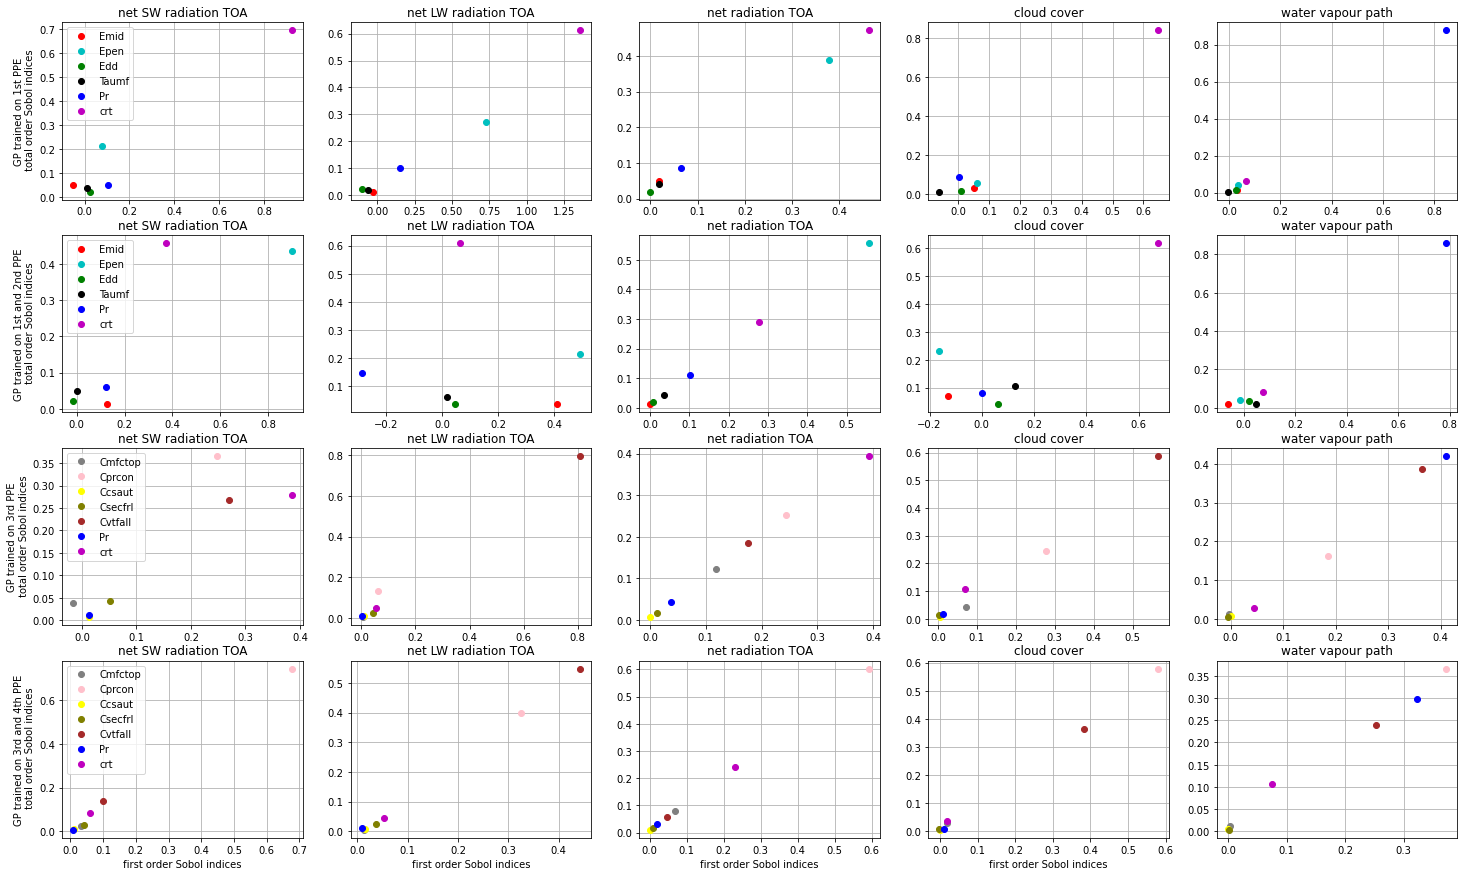

In [13]:
names_metrics=['net SW radiation TOA', 'net LW radiation TOA', 'net radiation TOA',  'cloud cover','water vapour path']#,'tauu on NAO','tauu on SOO','ua at 60N and 10hPa','ua at 60S and 10hPa']
parameters_list1 =['Emid','Epen','Edd','Taumf', 'Pr', 'crt']
colors1=['r','c','g','k','b','m']
parameters_list2=['Cmfctop', 'Cprcon', 'Ccsaut', 'Csecfrl', 'Cvtfall', 'Pr', 'crt']
colors2=['gray','pink','yellow','olive','brown', 'b','m']
leg_case=['1st PPE','1st and 2nd PPE','3rd PPE', '3rd and 4th PPE']

fontsize=10
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['figure.figsize'] = [25, 15]

fig = plt.figure()
nparam=[6,6,7,7]  
iplot=0
ncase=4
for icase in np.arange(ncase):
    if (icase==0 or icase==1):
        param=parameters_list1
        col=colors1
    if (icase==2 or icase==3):
        param=parameters_list2
        col=colors2
    for ioutput in np.arange(noutputs):# 5 outputs
        ax = fig.add_subplot(4,5,iplot+1)
        for iparam in np.arange(nparam[icase]):
            plt.plot(indicesall[icase][0][ioutput][iparam],indicesall[icase][1][ioutput][iparam],'o',color=col[iparam],label=param[iparam])
        if iplot in np.arange(0,ncase*noutputs-1,noutput):
            plt.legend()
            plt.ylabel('GP trained on '+leg_case[icase]+'\n total order Sobol indices')
        if iplot in np.arange((ncase-1)*noutputs,ncase*noutputs-1):
            plt.xlabel('first order Sobol indices')
        plt.title(names_metrics[ioutput])
        plt.grid()
        iplot+=1
    plt.savefig('PaperFig/all_Sobol_indices_PhysicsOutputs.png')